In [1]:
%load_ext autoreload
%autoreload 1

%aimport src.utils.tardisml_utils

In [2]:
%reload_ext autoreload

In [3]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl

from src.data_preparation import mdl_dataset_prep as dataset_prep

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca
import src.visualization.visualize_pca as visualize_pca
import src.visualization.visualize_error as visualize_error
from src.visualization import mdl_introspect

from src.data_preparation.blocking_time_series_split import BlockingTimeSeriesSplit 
from src.data_preparation import mdl_dataset_prep
from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

login-2.fram.sigma2.no
fram detected
login-2.fram.sigma2.no
fram detected
login-2.fram.sigma2.no
fram detected
login-2.fram.sigma2.no
fram detected
login-2.fram.sigma2.no
fram detected


In [4]:
# Date to plot in example
idate = 100
# Path to config file
file_config = '../config/data_proc_demo.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template),Loader=yaml.FullLoader)
load_config.update_config(file_config, verbose=True)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config, verbose=True)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)
ml_model, nseq, params = load_config.load_ml_params(file_config)

PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881
Config file updated (pca_dir): ../config/data_proc_demo.yaml
Config file updated: ../config/data_proc_demo.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220919-162316
Folder created

Config file updated.


In [5]:
# copy config file to results
!cp {file_config} {rootdir+res_dir}

- mslprs: Mean sea-level pressure
- airtmp: Air temperature

## Define chronology

In [6]:
# The chronology is the same for all forcing fields
# Just take the first one

# df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'{forcing_fields[0]}.pkl'))
df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'mslprs.pkl'))
chrono = df[df.time%1==timeofday].date

chrono.iloc[idate]

Timestamp('2014-04-11 12:00:00')

## Get land mask

In [7]:
mskok1d, mskok = load_data.get_land_mask(lim_idm, lim_jdm, rootdir, pca_dir)

## Construct train/val/test dataset

#### Loading Target var PCA WITHOUT SIT assimilation

In [8]:
data_kind = "nosit"
n_components = load_config.get_n_components(data_kind, file_config)
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_noSITass.pkl")
pca_f = load_data.load_pca(filename)

Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hice00_4N_noSITass.pkl



In [9]:
# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_noSITass.nc")
Xf, mu_f, RMSE_f = load_data.load_nc(filename, target_field)

In [10]:
# retrieve PC and EOF values
PCs_f = feature_pca.pca_to_PC(pca_f, Xf, mskok1d)

EOF1d_f, EOF2d_f = feature_pca.compute_eof(n_components, Xf, pca_f, mskok)

In [11]:
# Reconstruction from PCA
Xf_rec = xr.dot(EOF2d_f,PCs_f) + mu_f

# RMSE for comparison with RMSE predicted by ML
RMSE_recf = np.sqrt((np.square(Xf_rec-Xf)).mean(dim='rdim'))

---

#### Loading ERROR of Target var PCA SIT assimilation - no assimilation

In [12]:
data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)
filename = os.path.join(rootdir,pca_dir,f"pca_{target_field}_{n_components}N_SITerr.pkl")
pca_e = load_data.load_pca(filename)

Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hice00_4N_SITerr.pkl



In [13]:
# load X, mu, RMSE
filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_SITerr.nc")
Xe, mu_e, RMSE_e = load_data.load_nc(filename, target_field)

In [14]:
# retrieve PC and EOF values
PCs_e = feature_pca.pca_to_PC(pca_e, Xe, mskok1d)

EOF1d_e, EOF2d_e = feature_pca.compute_eof(n_components, Xe, pca_e, mskok)

In [15]:
# Reconstruction from PCA
Xe_rec = xr.dot(EOF2d_e,PCs_e) + mu_e

# RMSE for comparison with RMSE predicted by ML
RMSE_rece = np.sqrt((np.square(Xe_rec-Xe)).mean(dim='rdim'))

---

#### Loading covariable PCA - noSIT assimilation
that could help the sea-ice thickness prediction such as:

- fice: fraction of sea ice
- hsnow: snowdepth
- age ice

In [16]:
data_kind = "covariable"
n_components = load_config.get_n_components(data_kind, file_config)

In [17]:
PCs_co = load_data.load_covariables(covar_fields, mskok1d, pca_dir, n_components)

Retrieve fice00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_fice00_4N_noSITass.pkl

Retrieve hsnw00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hsnw00_4N_noSITass.pkl

Retrieve ssh00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_ssh00_4N_noSITass.pkl

Retrieve vice00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_vice00_4N_noSITass.pkl

Retrieve uice00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_uice00_4N_noSITass.pkl

Retrieve swflx00
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_swflx00_4N_noSITass.pkl



#### Loading covariable WITHOUT PCA


In [18]:
data_kind = "covariable"
dsCo = {}
for covar in covar_fields:
#     print(covar)
    filename = os.path.join(rootdir,pca_dir,f"{covar}_forecast_noSITass.nc")
    tmp = load_data.load_nc(filename, covar, X_only=True)
    dsCo[f'{covar[:6]}'] = np.mean(tmp, axis=(1,2)).data[:, None]
    

In [19]:
print('ATTENTION COVARIABLE SANS PCA NONT PAS DE MASQUE !!')
print('verifier forcing')

ATTENTION COVARIABLE SANS PCA NONT PAS DE MASQUE !!
verifier forcing


#### Loading forcings PCA

In [20]:
data_kind = "forcing"
filename = load_config.get_pca_filename(data_kind, file_config, pca_dir)

In [21]:
PCs, EOFs = load_data.load_forcing_PC_EOF(filename, forcing_bdir, forcing_fields)

Loading forcing values
Loading pca
Load PCA: /nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_airtmp-mslprs-vapmix-precip-wndewd-wndnwd-radflx-shwflx_4N_21d.pkl

Retrieve PCs and EOFs


#### Loading forcings (without PCA)

In [22]:
# dataset Forcings
dsFo = {}

In [23]:
for forcing in forcing_fields:
#     print(forcing)
    tmp = pkl.load(open(f'{rootdir}{pca_dir}/{forcing}.pkl','rb'))
    dsFo[f'{forcing[:6]}'] = np.mean(tmp, axis=(1))[:, None]
    

- --

### Preparing the dataset

- --

In [24]:
# from src.data_preparation.mdl_dataset_prep import target_history # as target_history
# from src.data_preparation import mdl_dataset_prep # as target_history


In [25]:
# all H index at 0 for LSTM
H = 1
H_neg = 0
Hnc = 1
Hnc_neg = 0
Hfo = 1
Hfo_neg = 0
Hco = 1
Hco_neg = 0

In [26]:
# 3 types of predictors
# Xtp: The same as the target at t+1, (t+2, t+3, ...)
# Xnc: Forecast for the non corrected model at time t, (t-N, ..., t+N)
# Xfo: forcings at t (t-N, ..., t+N)
# Xco: covariables from the non corrected model at time t, (t-N, ..., t+N)
# We invert the time axis

# H = 4  # Xtp
# H = params['History'][params['type_var_short'].index('tp')]
# H_neg = params['History_neg'][params['type_var_short'].index('tp')]
Xtp, nhypfeat, hyplabels = mdl_dataset_prep.target_history(PCs_e.values[::-1], H, H_neg, f'Xe', False)  # 'PCa'


# Hnc = 2  # 0  # Xnc
# Hnc = params['History'][params['type_var_short'].index('nc')]
# Hnc_neg = params['History_neg'][params['type_var_short'].index('nc')]
Xnc, _, nclabels = mdl_dataset_prep.target_history(PCs_f.values[::-1], Hnc, Hnc_neg, 'SITf')  # 'PCna'


# Hfo = 1  # Xfo
# Hfo = params['History'][params['type_var_short'].index('fo')]
# Hfo_neg = params['History_neg'][params['type_var_short'].index('fo')]
folabels = []
# Xfo  = np.concatenate([PCs[field] for field in forcing_fields],axis=1)[::-1][:-1]

for idx, field in enumerate(forcing_fields):
    fotmp, _, folab = mdl_dataset_prep.target_history(PCs[field][::-1], Hfo, Hfo_neg, field[:6])
    folabels += folab
    if idx == 0:  # field == forcing_fields[0]:
        Xfo = fotmp
        continue
    Xfo = np.hstack([Xfo, fotmp])
    

# covariable Xco
# Hco = 1
# Hco = params['History'][params['type_var_short'].index('co')]
# Hco_neg = params['History_neg'][params['type_var_short'].index('co')]
colabels = []

for idx, covar in enumerate(covar_fields):
    cotmp, _, colab = mdl_dataset_prep.target_history(PCs_co[covar][::-1], Hco, Hco_neg, covar[:6])
    colabels += colab
    if idx == 0:  # field == forcing_fields[0]:
        Xco = cotmp
        continue
    Xco = np.hstack([Xco, cotmp])

# forcing without PCA
flabels = []

for idx, field in enumerate(forcing_fields):
    ftmp, _, flab = mdl_dataset_prep.target_history(dsFo[field[:6]][::-1], Hfo, Hfo_neg, field[:6],label_pca=False)
    flabels += flab
    if idx == 0:  # field == forcing_fields[0]:
        DSfo = ftmp
        continue
    DSfo = np.hstack([DSfo, ftmp])
    
# covariable WITHOUT PCA
clabels = []

for idx, covar in enumerate(covar_fields):
    ctmp, _, clab = mdl_dataset_prep.target_history(dsCo[covar[:6]][::-1], Hco, Hco_neg, covar[:6],label_pca=False)
    clabels += clab
    if idx == 0:  # field == forcing_fields[0]:
        DSco = ctmp
        continue
    DSco = np.hstack([DSco, ctmp])
    
    

----------

History selection improved: BIAS of SIT

In [27]:
# make dictionary history for forcing

# interval = 3
# nexplo = 5
# must_be = [i for i in range(1, 3+1)]
# fo_to_explore=['airtmp', 'mslprs', 'precip','vapmix','wndewd','wndnwd']

# fo_hist = mdl_dataset_prep.make_fo_history(forcing_fields, fo_to_explore)
# make_fo_history(forcing_fields, fo_to_explore=['airtmp', 'mslprs'], must_be=[1,2,3], interval=3, nexplo=5)

----------

History selection improved: forcing selection

In [28]:
forcing_fields

['airtmp_mean21d',
 'mslprs_mean21d',
 'vapmix_mean21d',
 'precip_mean21d',
 'wndewd_mean21d',
 'wndnwd_mean21d',
 'radflx_mean21d',
 'shwflx_mean21d']

In [29]:
forcing_fields = sorted(forcing_fields)

In [30]:
# make dictionary history for forcing

# interval = 3
# nexplo = 5
# must_be = [i for i in range(1, 3+1)]
fo_to_explore=['airtmp', 'mslprs', 'precip','vapmix','wndewd','wndnwd']

fo_hist = mdl_dataset_prep.make_fo_history(forcing_fields, fo_to_explore)
# make_fo_history(forcing_fields, fo_to_explore=['airtmp', 'mslprs'], must_be=[1,2,3], interval=3, nexplo=5)

In [31]:
fo_hist

{'airtmp_mean21d': [1, 2, 3, 6, 9, 12, 15, 18],
 'mslprs_mean21d': [1, 2, 3, 6, 9, 12, 15, 18],
 'precip_mean21d': [1, 2, 3, 6, 9, 12, 15, 18],
 'radflx_mean21d': [1, 2, 3],
 'shwflx_mean21d': [1, 2, 3],
 'vapmix_mean21d': [1, 2, 3, 6, 9, 12, 15, 18],
 'wndewd_mean21d': [1, 2, 3, 6, 9, 12, 15, 18],
 'wndnwd_mean21d': [1, 2, 3, 6, 9, 12, 15, 18]}

In [32]:
Xfo, folabels, fohyperfeat = mdl_dataset_prep.forcing_history(forcing_fields, PCs, fo_hist)

----------

History selection improved: covar selection

In [33]:
covar_fields

['fice00', 'hsnw00', 'ssh00', 'vice00', 'uice00', 'swflx00']

In [34]:
covar_fields = sorted(covar_fields)

In [35]:
# make dictionary history for forcing

# interval = 3
# nexplo = 5
# must_be = [i for i in range(1, 3+1)]
co_to_explore=['hsnw00']

co_hist = mdl_dataset_prep.make_fo_history(covar_fields, co_to_explore)
# make_fo_history(forcing_fields, fo_to_explore=['airtmp', 'mslprs'], must_be=[1,2,3], interval=3, nexplo=5)

In [36]:
co_hist

{'fice00': [1, 2, 3],
 'hsnw00': [1, 2, 3, 6, 9, 12, 15, 18],
 'ssh00': [1, 2, 3],
 'swflx00': [1, 2, 3],
 'uice00': [1, 2, 3],
 'vice00': [1, 2, 3]}

In [37]:
Xco, colabels, cohyperfeat = mdl_dataset_prep.forcing_history(covar_fields, PCs_co, co_hist)

----------

In [27]:
# -------- assemble final dataset --------
    
# without covariables
# X = np.concatenate((Xtp, Xnc, Xfo),axis=1)
# totlabels = hyplabels + nclabels + folabels

# with covariables
X = np.concatenate((Xtp, Xnc, Xfo, Xco),axis=1)
totlabels = hyplabels + nclabels + folabels + colabels

# without Xtp
# X = np.concatenate((Xnc, Xfo, Xco),axis=1)
# totlabels = nclabels + folabels + colabels

# without forcing
# X = np.concatenate((Xtp, Xnc),axis=1)
# totlabels = hyplabels + nclabels

# everything + forcing without PCA
X = np.concatenate((Xtp, Xnc, Xfo, Xco, DSco, DSfo),axis=1)
pca_labels = hyplabels + nclabels + folabels + colabels 
totlabels = hyplabels + nclabels + folabels + colabels + clabels + flabels



y = PCs_e.values[::-1][1:]  # target var t

In [28]:
X.shape

(1460, 156)

In [29]:
y.shape

(1460, 4)

In [30]:
totlabels

['Xe t+1 PC0',
 'Xe t+1 PC1',
 'Xe t+1 PC2',
 'Xe t+1 PC3',
 'Xe t+2 PC0',
 'Xe t+2 PC1',
 'Xe t+2 PC2',
 'Xe t+2 PC3',
 'SITf t+0 PC0',
 'SITf t+0 PC1',
 'SITf t+0 PC2',
 'SITf t+0 PC3',
 'SITf t+1 PC0',
 'SITf t+1 PC1',
 'SITf t+1 PC2',
 'SITf t+1 PC3',
 'airtmp t+0 PC0',
 'airtmp t+0 PC1',
 'airtmp t+0 PC2',
 'airtmp t+0 PC3',
 'airtmp t+1 PC0',
 'airtmp t+1 PC1',
 'airtmp t+1 PC2',
 'airtmp t+1 PC3',
 'mslprs t+0 PC0',
 'mslprs t+0 PC1',
 'mslprs t+0 PC2',
 'mslprs t+0 PC3',
 'mslprs t+1 PC0',
 'mslprs t+1 PC1',
 'mslprs t+1 PC2',
 'mslprs t+1 PC3',
 'vapmix t+0 PC0',
 'vapmix t+0 PC1',
 'vapmix t+0 PC2',
 'vapmix t+0 PC3',
 'vapmix t+1 PC0',
 'vapmix t+1 PC1',
 'vapmix t+1 PC2',
 'vapmix t+1 PC3',
 'precip t+0 PC0',
 'precip t+0 PC1',
 'precip t+0 PC2',
 'precip t+0 PC3',
 'precip t+1 PC0',
 'precip t+1 PC1',
 'precip t+1 PC2',
 'precip t+1 PC3',
 'wndewd t+0 PC0',
 'wndewd t+0 PC1',
 'wndewd t+0 PC2',
 'wndewd t+0 PC3',
 'wndewd t+1 PC0',
 'wndewd t+1 PC1',
 'wndewd t+1 PC2',
 'w

----------

In [32]:
nfeat = y.shape[1]

In [33]:
inputs = [f'{item} PCA' for item in pca_labels[::nfeat]] + clabels + flabels

In [34]:
# new inputs with new history 

inputs = totlabels

# pca_labels = hyplabels + nclabels + folabels + colabels 
# totlabels = hyplabels + nclabels + folabels + colabels + clabels + flabels

In [35]:
# n_noPCA = len(clabels) + len(flabels)
# full_label = [f'{item} PC{n%nfeat}' for n,item in enumerate(totlabels[:-n_noPCA])] + [f'{item}' for item in totlabels[-n_noPCA:]]
full_label = totlabels

In [43]:
# print('todo: do a function to get params H and H negative')

#### Split the dataset

In [31]:
ntest, nval, ntrain, nsplit = dataset_prep.compute_dataset_splits(y)
print(f'Number of split for CV: {nsplit}')
# nsplit = 2

Number of split for CV: 3


In [32]:
# %%capture cap --no-stderr

Xtrain, ytrain = X[:ntrain+nval], y[:ntrain+nval]

print(f'Size of the training set:   {ntrain} days')
print(f'Size of the validation set: {nval}')
print(f'\nSize of the test set:       {ntest}')

Size of the training set:   735 days
Size of the validation set: 360

Size of the test set:       365


In [33]:
# from src.modelling. model_utils import add_output_2txt
# add_output_2txt(fl_out, cap)  # save output to .txt file
# print(cap)

#### Addition of noise

In [34]:
# Add some noise to the Xtp feature to avoid overfitting
# nfeat = Xtp.shape[1] // (H+H_neg+1)
nhyperfeat = Xtp.shape[1]

# nfeat = ytrain.shape[1]

Xtrain, noise = dataset_prep.add_noise(Xtrain, nhyperfeat, pert=1)


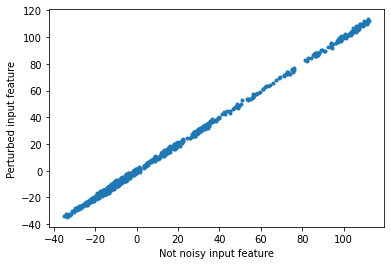

In [37]:
ch = 0
plt.plot(Xtrain[:,ch] - noise[:,ch], Xtrain[:,ch],'.')
plt.xlabel('Not noisy input feature')
plt.ylabel('Perturbed input feature');

In [38]:
X[:ntrain+nval].shape

(1095, 156)

In [39]:
print('ML is given the following inputs:')
inputs

ML is given the following inputs:


['Xe t+1 PC0',
 'Xe t+1 PC1',
 'Xe t+1 PC2',
 'Xe t+1 PC3',
 'Xe t+2 PC0',
 'Xe t+2 PC1',
 'Xe t+2 PC2',
 'Xe t+2 PC3',
 'SITf t+0 PC0',
 'SITf t+0 PC1',
 'SITf t+0 PC2',
 'SITf t+0 PC3',
 'SITf t+1 PC0',
 'SITf t+1 PC1',
 'SITf t+1 PC2',
 'SITf t+1 PC3',
 'airtmp t+0 PC0',
 'airtmp t+0 PC1',
 'airtmp t+0 PC2',
 'airtmp t+0 PC3',
 'airtmp t+1 PC0',
 'airtmp t+1 PC1',
 'airtmp t+1 PC2',
 'airtmp t+1 PC3',
 'mslprs t+0 PC0',
 'mslprs t+0 PC1',
 'mslprs t+0 PC2',
 'mslprs t+0 PC3',
 'mslprs t+1 PC0',
 'mslprs t+1 PC1',
 'mslprs t+1 PC2',
 'mslprs t+1 PC3',
 'vapmix t+0 PC0',
 'vapmix t+0 PC1',
 'vapmix t+0 PC2',
 'vapmix t+0 PC3',
 'vapmix t+1 PC0',
 'vapmix t+1 PC1',
 'vapmix t+1 PC2',
 'vapmix t+1 PC3',
 'precip t+0 PC0',
 'precip t+0 PC1',
 'precip t+0 PC2',
 'precip t+0 PC3',
 'precip t+1 PC0',
 'precip t+1 PC1',
 'precip t+1 PC2',
 'precip t+1 PC3',
 'wndewd t+0 PC0',
 'wndewd t+0 PC1',
 'wndewd t+0 PC2',
 'wndewd t+0 PC3',
 'wndewd t+1 PC0',
 'wndewd t+1 PC1',
 'wndewd t+1 PC2',
 'w

## A first simple model

In [37]:
from sklearn.model_selection import TimeSeriesSplit

from src.visualization.time_serie_split import PlotTimeSerieSplit

In [38]:
nsplit = 2
max_test_size = int(Xtrain.shape[0]/(nsplit +1))


In [39]:
ts_cv = TimeSeriesSplit(
    n_splits=nsplit,
    gap=0,
    max_train_size=ntrain,
   test_size=max_test_size,
)
# test_size = nval -> train dataset too small for the first split

In [40]:
# unique train/test split
# indexes = np.arange(X.shape[0])[:]
# idx_test = indexes[ntrain+nval:ntrain+nval+ntest]
# idx_train = indexes[:ntrain+nval]
# tt = [(idx_train, idx_test)]

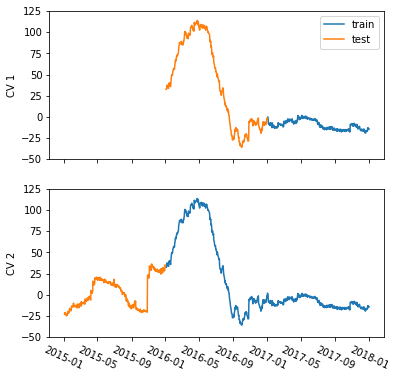

In [41]:
PlotTimeSerieSplit(ts_cv, Xtrain, chrono, rootdir+fig_dir, False, True)

----

In [50]:
# bts_cv = BlockingTimeSeriesSplit(3)
# PlotTimeSerieSplit(bts_cv, Xtrain[:,:], chrono, rootdir+fig_dir, False, True)

----

### Initialize variables and model parameters

#### Input variables

In [51]:
# additional parameters for the model

# cross validation
n_iter_bay = 100
bayesian_search = False
return_train_score = False
introspect = False

# input variables
input_dico = ''  # default: all variables

# load input_dico, to set selection directly
# ! need same X !
# idir = '/nird/projects/nird/NS2993K/Leo/results/'

# idir = '/cluster/work/users/leoede/Leo/results/grdbst_Npred22_2F_rw21d_N4444_H1333_Hn0000_hice00_artc_220816-205402/ml/'
# ifile = 'input_dico_01.npy'

idir = '/nird/projects/nird/NS2993K/Leo/results/grdbst_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc/ml/'
ifile = 'input_dico.npy'
# dicoback = np.load(f'{idir}{ifile}', allow_pickle=True)
# input_dico = dicoback[None][0]

# load model
# model_to_load = ''


In [52]:
input_dd = mdl_input_dico.InputDico()
input_dd.init_true(4, totlabels)
# input_dd.keep_only_best(ml_model)

In [53]:
# input_dd.switch_to_true(folabels)

In [54]:
# input_dd.switch_to_true(hyplabels)

In [55]:
# input_dd.switch_to_false(['Xe t+1 PC0', 'la', 'Xe t+2 PC2', 'Xtp'])
# input_dd.switch_to_true(['airtmp t+3 PC0', 'airtmp t+6 PC0','airtmp t+9 PC0','airtmp t+12 PC0'])

----

----

#### GridSearch params / Model Params

In [56]:
param = mdl_params.Params(ml_model, 4)

# param.get_search(booster='dart')
param.optimize(random_state=0, booster='dart')

In [57]:
# param.param_opt

###  Graph conv LSTM
from https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

In [35]:
from tensorflow.keras import layers
import typing
import tensorflow as tf

2022-09-19 16:25:00.487099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 16:25:00.487511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [36]:
from tensorflow import keras

In [37]:
import tensorflow_addons as tfa

In [38]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


In [39]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


In [40]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

        


### Build Dataset

In [41]:
def scale_data2D_var(train_data, test_data):
    '''scale each variable btw 0 and 1
    
    for train_data, test_data: format (sample, timestep, features)
    '''
    train_scaled = train_data.copy()
    test_scaled = test_data.copy()
    
    
    for var in range(train_data.shape[1]):
        max_val = train_data[:,var].max()
        min_val = train_data[:,var].min()
        train_scaled[:,var] = (train_data[:,var] - min_val) / (max_val - min_val)
        test_scaled[:,var] = (test_data[:,var] - min_val) / (max_val - min_val)
    return train_scaled, test_scaled

In [42]:
# get index most imp
# most imp for PC0
# most_imp = ['SITf t+0 PC0', 'hsnw00 t+0 PC1', 'SITf t+0 PC1', 'hsnw00 t+0 PC3', 'SITf t+0 PC2',
#                       'hsnw00 t+0 PC1', 'airtmp t+0 PC1', 'hsnw00 t+0 PC2', 'airtmp t+0 PC3',
#                       'hsnw00 t+0 PC3'] + \
#             ['mslprs t+0', 'wndewd t+0', 'precip t+0']

# most_imp = ['SITf t+0 PC0', 'hsnw00 t+0 PC1', 'airtmp t+0 PC1'] #  'mslprs t+0'] # , 'airtmp t+0']


most_imp = ['SITf t+0', 'hsnw00 t+0', 'airtmp t+0', 'mslprs t+0', 'precip t+0','wndewd t+0']


indexes = []

for mi in most_imp:
    for idx, lb in enumerate(totlabels):
        if mi in lb:
            indexes.append(idx)

In [43]:
H = [0]  # ,7,14,21,28, 35, 42]

In [46]:
ds3 = build_dataset_1pt(X, y, chrono, train_p=3/4, times=H)

In [47]:
# select only hsnw00 t+0 PC0'
ds3[0]['Xtrain']= ds3[0]['Xtrain'][:, indexes]
ds3[0]['Xtest']= ds3[0]['Xtest'][:, indexes]

In [48]:
ds3[0]["Xtrain"].shape

(1095, 29)

In [49]:
# rescale for data - OTHER METHOD
ds3[0]["Xtrain"], ds3[0]["Xtest"] = scale_data2D_var(ds3[0]["Xtrain"], ds3[0]["Xtest"])

In [50]:
# format (times, history, features)
ds3[0]['Xtrain'].shape

(1095, 29)

In [51]:
ds3[0]['ytrain'].shape

(1095, 4)

In [52]:
val_fraction = 0.2
idx_val = int(ds3[0]['Xtrain'].shape[0] * val_fraction)

With all 4 PCA as inputs

In [53]:
train_array = np.hstack([ds3[0]['ytrain'][idx_val:],ds3[0]['Xtrain'][idx_val:]])
val_array = np.hstack([ds3[0]['ytrain'][:idx_val],ds3[0]['Xtrain'][:idx_val]])

In [54]:
test_array = np.hstack([ds3[0]['ytest'], ds3[0]['Xtest']])

In [55]:
full_array = np.concatenate([test_array, val_array,train_array])

In [56]:
print(f'Train shape: {train_array.shape}')
print(f'Val shape: {val_array.shape}')
print(f'Test shape: {test_array.shape}')

Train shape: (876, 33)
Val shape: (219, 33)
Test shape: (365, 33)


#### Creating TensorFlow dataset

In [57]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

In [58]:
# reverse train and validation array
train_array = train_array[::-1]
val_array = val_array[::-1]
test_array = test_array[::-1]

In [59]:
batch_size = 128 # 64
input_sequence_length = 12  # 12
forecast_horizon = 12  # 3
multi_horizon = True # False

train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

full_dataset = create_tf_dataset(
    full_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=full_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

2022-09-19 16:31:35.147806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-19 16:31:35.199572: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 16:31:35.228661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-19 16:31:35.378732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define Graph 

Define edges between nodes

In [60]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask


In [61]:
# example for road traffic light (= osef)
# sigma2 = 0.1
# epsilon = 0.5
# adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)

# instead adjaceny_matrix with only ones
size_m = len(indexes) + 4
adjacency_matrix = np.ones(shape=(size_m, size_m))

node_indices, neighbor_indices = np.where(adjacency_matrix == 1)

graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)

print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 33, number of edges: 1089


### Model training

In [62]:
in_feat = 1
batch_size = 128  # 128  # 64
epochs = 100  # 100
input_sequence_length = 120  # 24  # 12
forecast_horizon = 120  # 3
multi_horizon = True # True  # False
out_feat = 10 # 10 - orignal
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)

#     metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=20)],
)


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_104303/3311759452.py", line 35, in <cell line: 35>
      history = model.fit(
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [128,120,33] vs. [128,12,33]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_2777]

## Plot evaluation

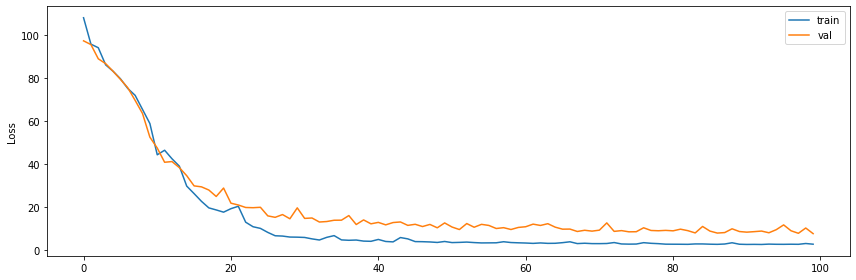

In [380]:
plot_learning_curves_2(history)

### Forecasts on test set

In [ ]:
x_test, y_true = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

naive MAE: 0.10073277475281212, model MAE: 0.324422812855438


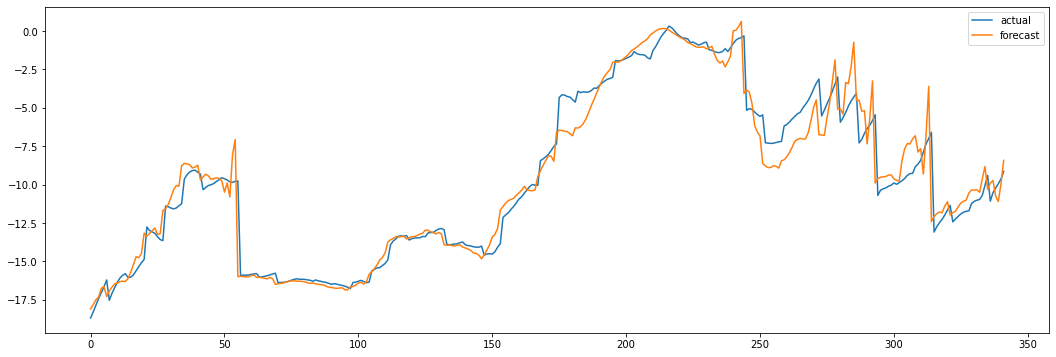

In [383]:
plt.figure(figsize=(18, 6))
plt.plot(y_true[::-1, 0, 0])
plt.plot(y_pred[::-1, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y_true[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y_true[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

11/11 [==============================] - 3s 27ms/step
naive MAE: 0.10073277475281212, model MAE: 0.5792627928745022


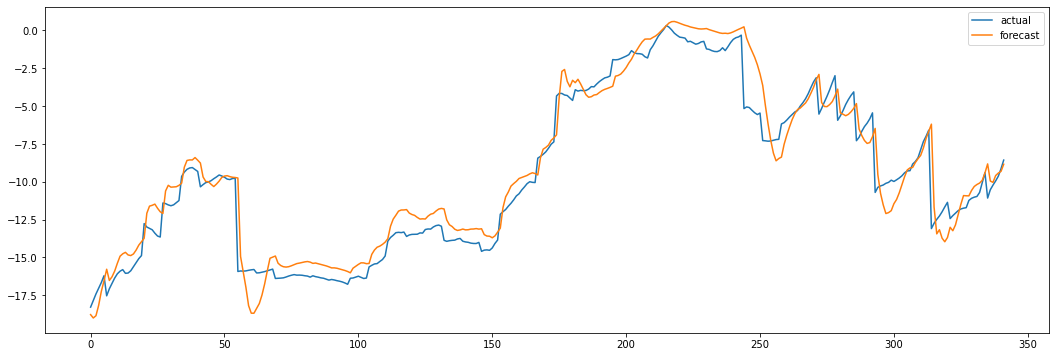

In [69]:
x_test, y_true = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y_true[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y_true[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y_true[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")


In [70]:
y_pred_mn = np.mean(y_pred, axis=(1))
y_pred_std = np.std(y_pred, axis=(1))

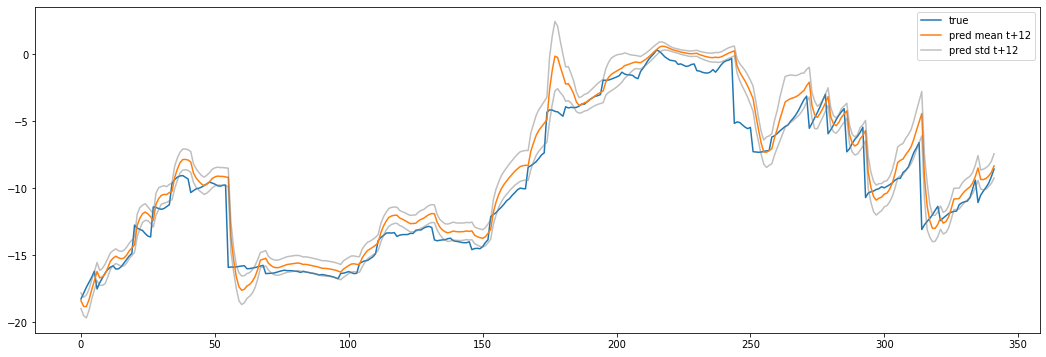

In [71]:
plt.figure(figsize=(18, 6))
plt.plot(y_true[:, 0, 0], label='true')
plt.plot(y_pred_mn[:, 0], label=f'pred mean t+{forecast_horizon}')
plt.plot(y_pred_mn[:, 0]+y_pred_std[:, 0], label=f'pred std t+{forecast_horizon}', c='grey', alpha=0.5)
plt.plot(y_pred_mn[:, 0]-y_pred_std[:, 0], c='grey', alpha=0.5)

plt.legend()



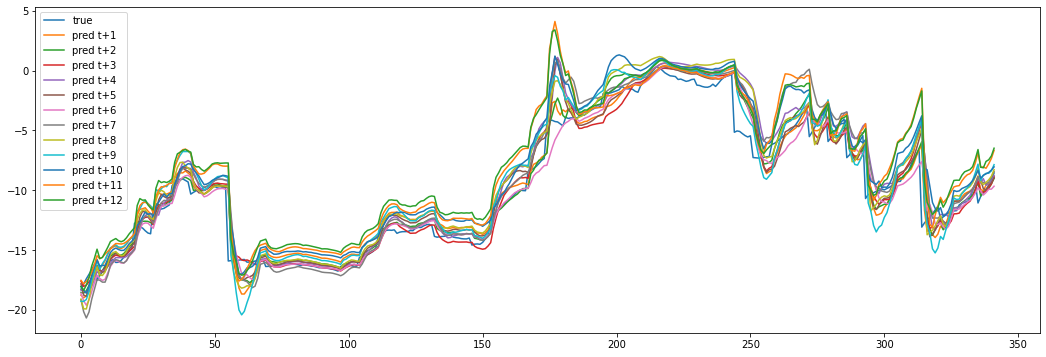

In [72]:
plt.figure(figsize=(18, 6))
plt.plot(y_true[:, 0, 0], label='true')


for nmh in range(forecast_horizon):
    plt.plot(y_pred[:, nmh, 0], label=f'pred t+{nmh+1}')

    
plt.legend()

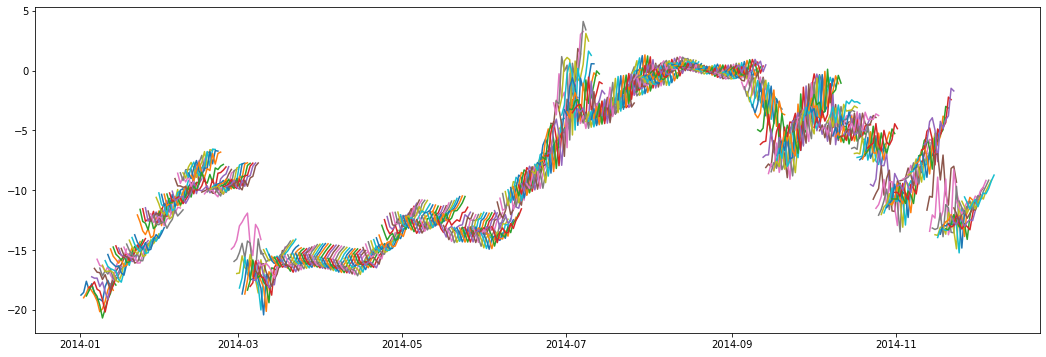

In [232]:
plt.figure(figsize=(18, 6))

for tps in range(y_pred.shape[0]-forecast_horizon):
    plt.plot(chrono[tps:tps+forecast_horizon], y_pred[tps, :, 0])    

Recurrent prediction for PC0 :

does not have any sense as LSTM is recurrent by design

In [322]:
nteacher = input_sequence_length
nteacher = 400

yrec = y_pred.copy()
yrec[nteacher:] *= 0

for ti in range(nteacher, y_pred.shape[0]):  # y_true.shape[0]):
#     print(ti)
    x_rec = x_test[ti,:].copy()  # all features at t0
#     x_rec[:, 0, :] = np.swapaxes(yrec[ti-1:ti, :, 0], 0, 1)  # remplace PC0 with estimate a t-1
#     x_rec[0, :4, :] = np.swapaxes(yrec[ti-1:ti, 0, :4],0,1)  # remplace PC0 with estimate a t-1
    x_rec[:, :4, 0] = yrec[ti-input_sequence_length:ti, 0, :4]  # remplace PC0 with estimate a t-1
    
    
    yrec[ti:ti+1] = model.predict(x_rec[None])

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [309]:
yrec.shape

(1437, 12, 33)

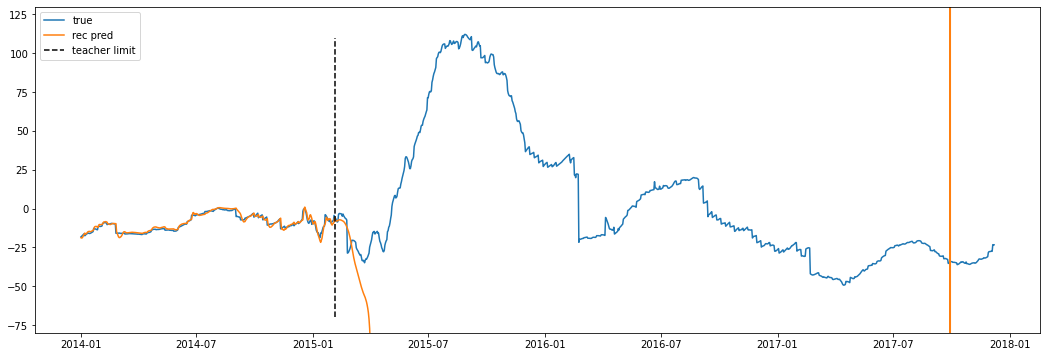

In [326]:
plt.figure(figsize=(18, 6))

ifeat=0
xlim = yrec.shape[0]

plt.plot(chrono[:xlim], y_true[:xlim, 0, ifeat], label='true')
plt.plot(chrono[:xlim], yrec[:, 0, ifeat], label='rec pred')

# plt.plot([chrono[nteacher:nteacher+1]]*2, [-29,4], 'k--', label='teacher limit')
plt.plot([chrono[nteacher:nteacher+1]]*2, [-70, 110], 'k--', label='teacher limit')


# plt.ylim([-30,5])
plt.ylim([-80,130])

plt.legend()

(-30.0, 5.0)

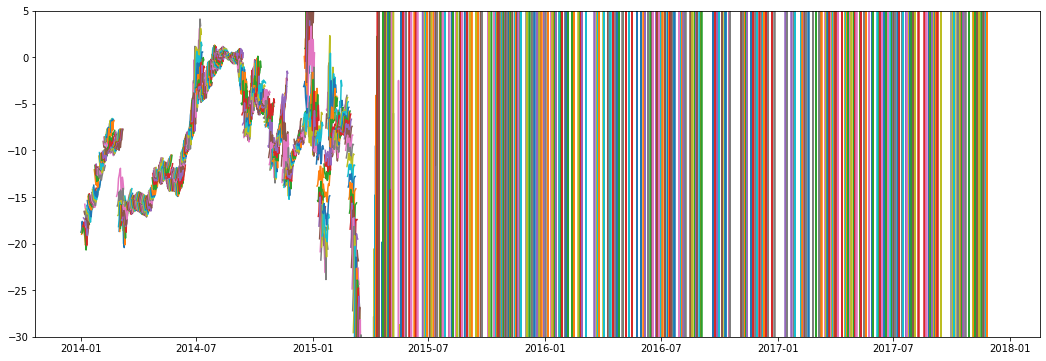

In [324]:
plt.figure(figsize=(18, 6))

# for nmh in range(forecast_horizon):
for tps in range(y_pred.shape[0]-forecast_horizon):
    plt.plot(chrono[tps:tps+forecast_horizon], yrec[tps, :, 0])    
    
plt.ylim([-30,5])


------
prediction on all on reverse order

BACK PREDICTION

In [354]:
x_test[:,::-1].shape

(1437, 12, 33, 1)

In [355]:
x_test, y_true = next(full_dataset.as_numpy_iterator())
y_predr = model.predict(x_test[:, ::-1])

45/45 [==============================] - 2s 12ms/step


In [361]:
y_predr_t = y_predr[:,::-1]  # future forward

naive MAE: 0.2996558614761199, model MAE: 186.73335913156671


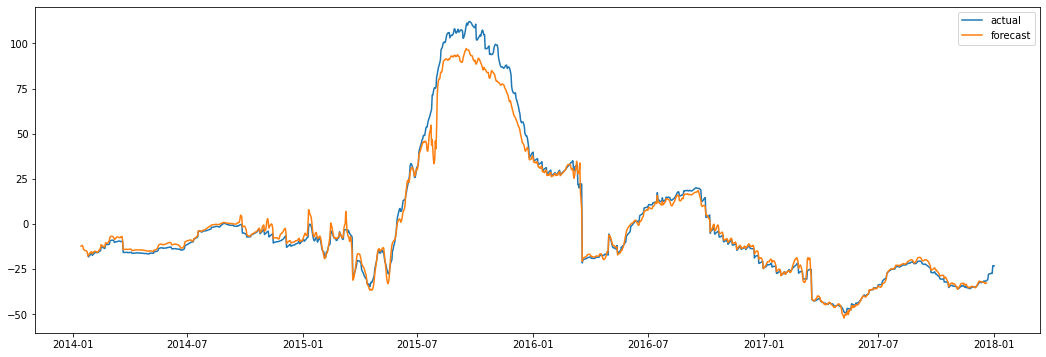

In [373]:
plt.figure(figsize=(18, 6))
plt.plot(chrono[24:], y_true[:, 0, 0])
plt.plot(chrono[12:-12], y_predr_t[:, 0, 0])
plt.legend(["actual", "forecast"])
# plt.plot([365]*2,[-45, 110], ':k', label='train limit')

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y_true[:, 0, :]).mean(),
    np.square(y_pred[::-1, 0, :] - y_true[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

In [345]:
y_predr.shape

(1437, 12, 33)

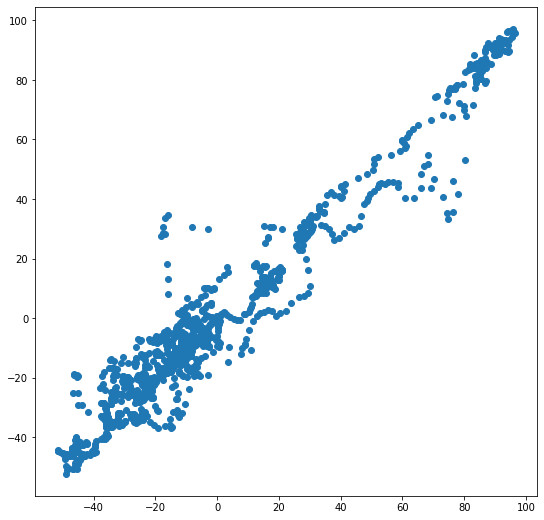

In [359]:
plt.figure(figsize=(9, 9))

# plt.scatter(y_pred[:,0,0], y_predr[::-1,0,0])
plt.plot(y_pred[:,0,0], y_predr[:,-1,0], 'o')

------
prediction on all dataset

In [337]:
x_test, y_true = next(full_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

45/45 [==============================] - 2s 12ms/step


naive MAE: 0.2996558614761199, model MAE: 1.3823893045879565


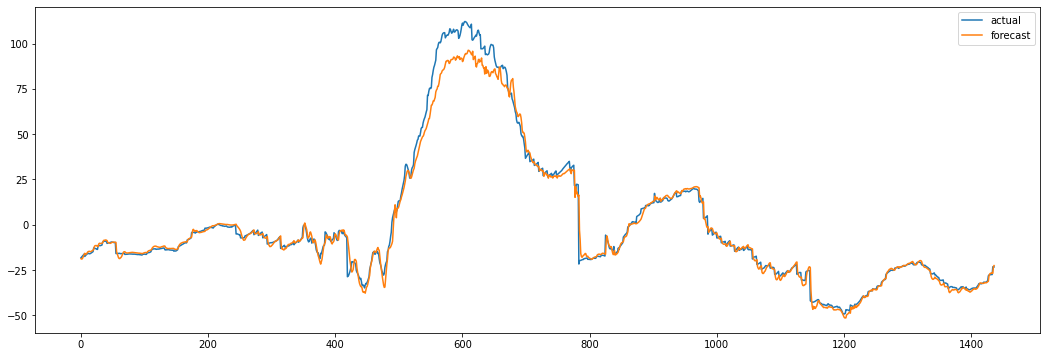

In [338]:
plt.figure(figsize=(18, 6))
plt.plot(y_true[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])
# plt.plot([365]*2,[-45, 110], ':k', label='train limit')


naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y_true[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y_true[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

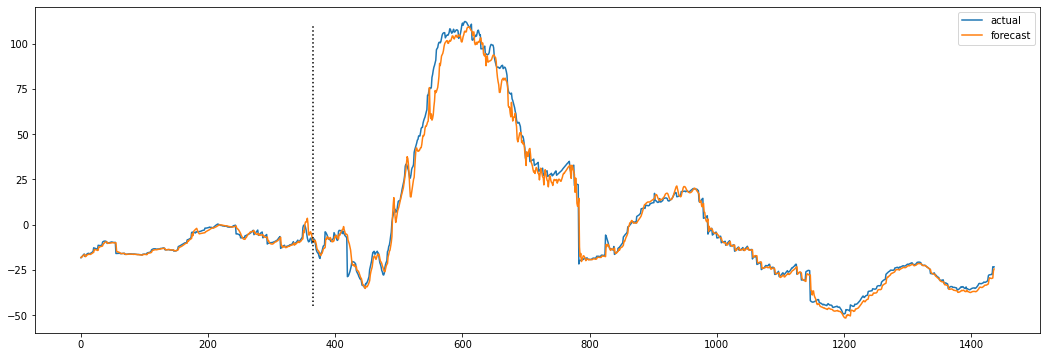

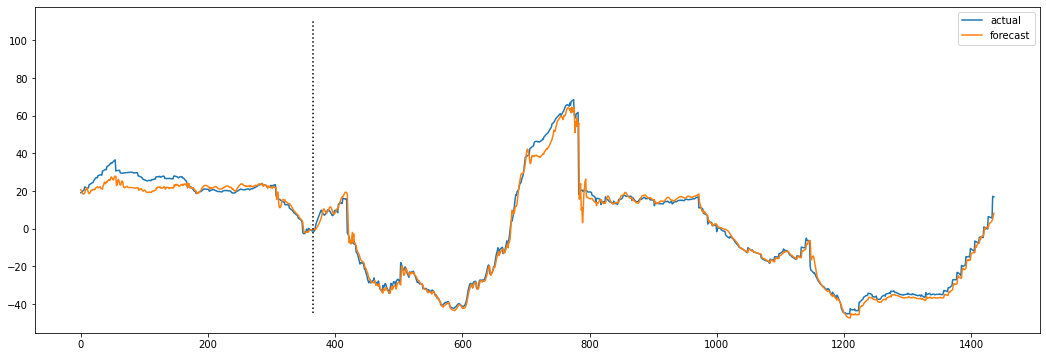

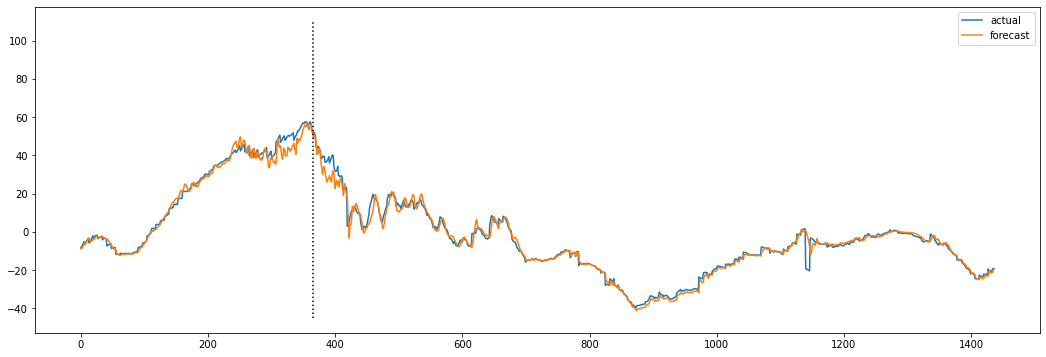

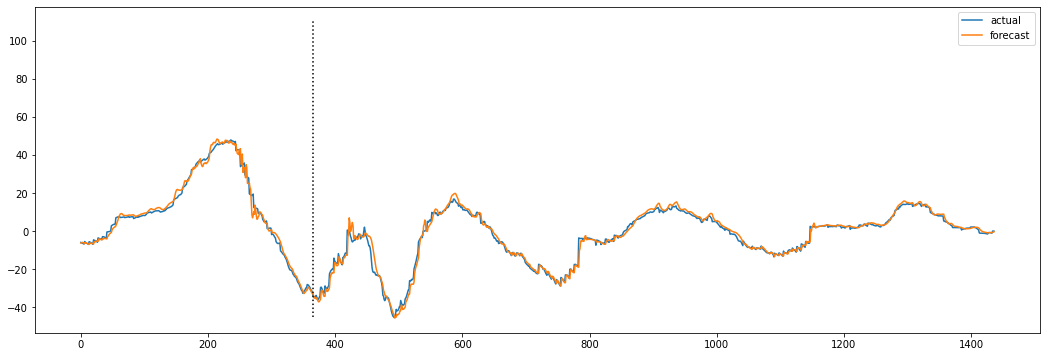

In [495]:
nfeat = 1

for nfeat in range(4):
    plt.figure(figsize=(18, 6))
    plt.plot(y_true[:, 0, nfeat])
    plt.plot(y_pred[:, 0, nfeat])
    plt.plot([365]*2,[-45, 110], ':k', label='train limit')
    plt.legend(["actual", "forecast"])

In [496]:
y_pred_mn = np.mean(y_pred, axis=(1))
y_pred_std = np.std(y_pred, axis=(1))

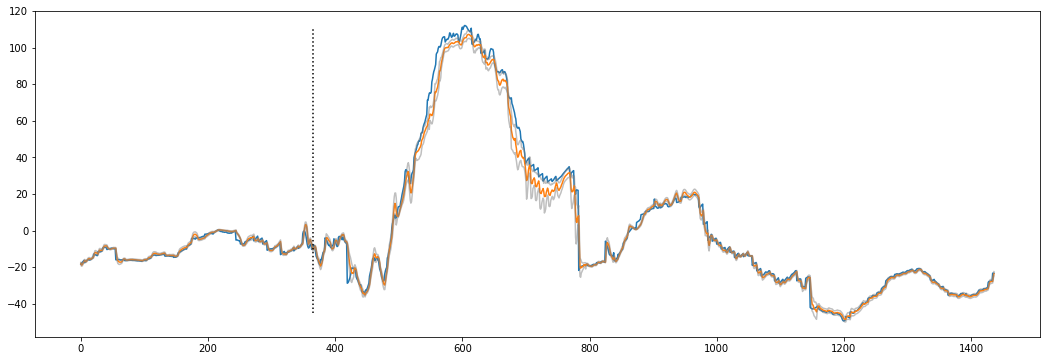

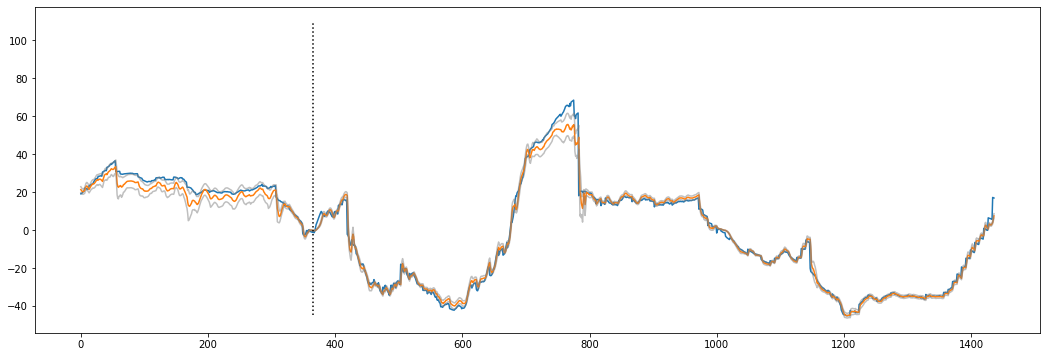

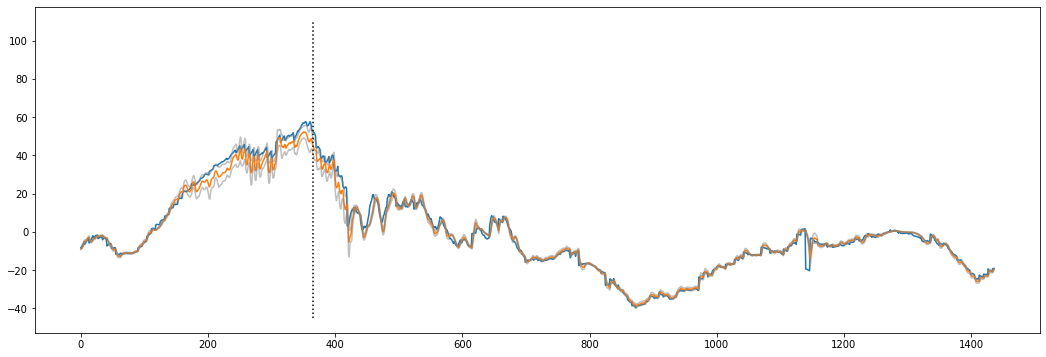

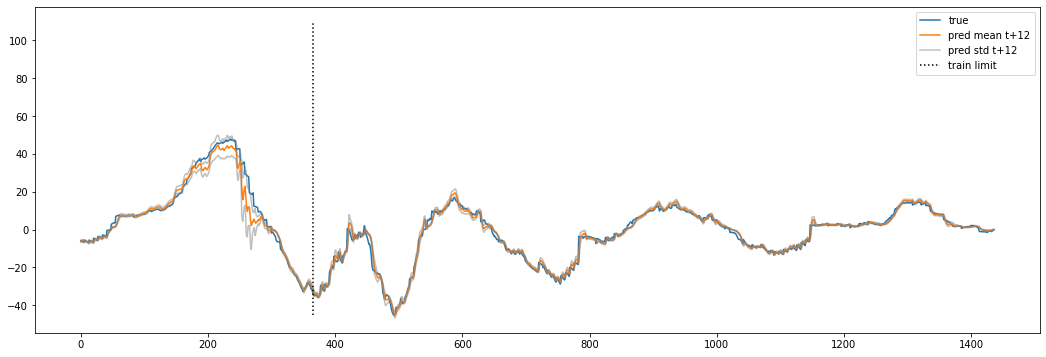

In [497]:

for nfeat in range(4):
    plt.figure(figsize=(18, 6))
    plt.plot(y_true[:, 0, nfeat], label='true')
    plt.plot(y_pred_mn[:, nfeat], label=f'pred mean t+{forecast_horizon}')
    plt.plot(y_pred_mn[:, nfeat]+y_pred_std[:, nfeat], label=f'pred std t+{forecast_horizon}', c='grey', alpha=0.5)
    plt.plot(y_pred_mn[:, nfeat]-y_pred_std[:, nfeat], c='grey', alpha=0.5)
    plt.plot([365]*2,[-45, 110], ':k', label='train limit')
    

plt.legend()



In [498]:
import shap

In [499]:
# init the JS visualization code
shap.initjs()

In [500]:
# DEEP EXPLAINER - works with 3D dataset


explainer = shap.DeepExplainer(model, train_dataset)  # only 100 values ? or 1000 ?
shap_values = explainer.shap_values(x_test)


AssertionError: The model output must be a vector or a single value!

In [42]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [ ]:
def GCNN():
    
    model = Sequential()
    model.add()

In [46]:
def LSTM_model(timesteps, features, units=30, reg=None):
    
    model = Sequential()
    model.add(LSTM(units = units, return_sequences = True, input_shape = (timesteps, features), recurrent_regularizer=reg))
    model.add(Dropout(0.1))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.1))

    model.add(LSTM(units = units))
    model.add(Dropout(0.1))

    model.add(Dense(units = 1))

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model

In [67]:
def plot_learning_curves_2(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(12,4))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train','val'])
#     ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

In [351]:
def plot_training_analysis(history):
    loss = history.history['loss']
    r2 = history.history['r_square']
    rmse = history.history['root_mean_squared_error']

    epochs = range(len(loss))

    plt.plot(epochs, rmse, 'b', linestyle="--",label='Training rmse')
    plt.plot(epochs, r2, 'g', linestyle="--",label='Training r2')
    plt.plot(epochs, loss, 'r', linestyle="--",label='Training loss')
    plt.title('Training stats')
    plt.legend()

    plt.show()
    
def plot_learning_curves(history):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,4*3))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train','val'])
#     ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    ax2.plot(history.history['r_square'])
    ax2.plot(history.history['val_r_square'])
    ax2.legend(['train','val'])
#     ax2.set_xlabel('Epochs')
    ax2.set_ylabel('r2')
    
    ax3.plot(history.history['root_mean_squared_error'])
    ax3.plot(history.history['val_root_mean_squared_error'])
    ax3.legend(['train','val'])
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('RMSE')
    
    plt.tight_layout()
    plt.show()
    
    
def print_res(model, dataset, batch_size=128, ens="test"):
    res = model.evaluate(dataset[0][f"X{ens}"], dataset[0][f"y{ens}"], batch_size=batch_size, verbose=0)
    for i, m in enumerate(model.metrics_names):
        print(f"{m} : {res[i]}")
    
    
def draw(model, x, y, chrono, ntest, twin=False):
    fig, ax = plt.subplots(figsize=(12,10))
    l1 = ax.plot(chrono[1:], y, label='true error')
    if twin:
        ax_twin = ax.twinx()
        l2 = ax_twin.plot(chrono, model.predict(x), label='prediction', color='orange')
    else:
        l2 = ax.plot(chrono[1:], model.predict(x, verbose=2), label='prediction')
    lab1 = l1+l2
    lab2 = [l.get_label() for l in lab1]
    plt.legend(lab1, lab2)
    plt.axvline(x=chrono.iloc[ntest], linestyle='dotted', color='grey', label='train limit')

In [209]:
def draw_prediction(ytrue, ypred, chrono, ntest, twin=False):
    fig, ax = plt.subplots(figsize=(12,10))
    l1 = ax.plot(chrono[1:], ytrue, label='true error')
    if twin:
        ax_twin = ax.twinx()
        l2 = ax_twin.plot(chrono, ypred, label='prediction', color='orange')
    else:
        l2 = ax.plot(chrono[1:], ypred, label='prediction')
    lab1 = l1+l2
    lab2 = [l.get_label() for l in lab1]
    plt.legend(lab1, lab2)
    plt.axvline(x=chrono.iloc[ntest], linestyle='dotted', color='grey', label='train limit')

In [99]:
def lauch_train(model, dataset, epochs=250, batch_size=128, print_arch_model=True, print_history=True, plot_draw=True):

    if print_arch_model:
        model.summary()
        plt.show()
        
    history = model.fit(dataset[0]["Xtrain"], dataset[0]["ytrain"], epochs=epochs, batch_size=batch_size, verbose=0,
                       validation_split=0.15, shuffle=True)

    if print_history:
#         plot_training_analysis(history)
        plot_learning_curves(history)
#         plt.show()

    if plot_draw:
        # for LSTM
        draw(model, np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"])), np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"])), dataset[2], dataset[1][2])
        # for CNN - bullshit
#         draw(model, np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"]), axis=(1)), np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"])), dataset[2], dataset[1][2])
        
        plt.show()

    print_res(model, dataset)
    
    return model

In [227]:
def fit_cnn_mh(model, dataset, epochs=250, batch_size=128, print_arch_model=True, print_history=True, plot_draw=True):

    if print_arch_model:
        model.summary()
        plt.show()
        
    history = model.fit([dataset[0]["Xtrain"]]*3, dataset[0]["ytrain"], epochs=epochs, batch_size=batch_size, verbose=0,
                       validation_split=0.15, shuffle=True)

    if print_history:
#         plot_training_analysis(history)
        plot_learning_curves(history)
#         plt.show()

    # predict 
    x = np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"]))
    ytrue = np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"]))
    ypred = model.predict([x]*3, verbose=1)



    if plot_draw:
        # for LSTM
#         draw(model, np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"])), np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"])), dataset[2], dataset[1][2])
        draw_prediction(ytrue, ypred, dataset[2], dataset[1][2])
        
        plt.show()

    print_res_mh(model, dataset)
    
    return model



    
def print_res_mh(model, dataset, batch_size=128, ens="test"):
    res = model.evaluate([dataset[0][f"X{ens}"]]*3, dataset[0][f"y{ens}"], batch_size=batch_size, verbose=0)
    for i, m in enumerate(model.metrics_names):
        print(f"{m} : {res[i]}")
    


In [223]:
def pred_cnn_mh(model, dataset):
    x = np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"]))
    ytrue = np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"]))
    ypred = model.predict([x]*3, verbose=1)
    
    return ypred

In [49]:
def fit_lstm(model, dataset, epochs=250, batch_size=128, print_arch_model=True, print_history=True, plot_draw=True):

    if print_arch_model:
        model.summary()
        plt.show()
        
    for i in range(epochs):    
        model.fit(dataset[0]["Xtrain"], dataset[0]["ytrain"], epochs=1, batch_size=batch_size, verbose=1,
                       shuffle=False)
        model.reset_states()

#     if print_history:
#         plot_learning_curves(history)

#     if plot_draw:
#         draw(model, np.concatenate((dataset[0]["Xtest"], dataset[0]["Xtrain"])), np.concatenate((dataset[0]["ytest"], dataset[0]["ytrain"])), dataset[2], dataset[1][2])
#         plt.show()

    print_res(model, dataset)
    
    return model

In [45]:
def scale_data(train_data, test_data):
    max_val = train_data.max()
    min_val = train_data.min()
    train_scaled = (train_data - min_val) / (max_val - min_val)
    test_scaled = (test_data - min_val) / (max_val - min_val)
    return train_scaled, test_scaled

def build_dataset_1pt(X, Y, chrono, exclude_cov=[], keep_fg=[], size_around=0, train_p=3/4, val_p=0, times=[0]):
    """ Construct the NN dataset of a single point.
    
    In: 
        point       : int list           --  (i, j) coordinates of the point for which we want to calculate the dataset
        cov_sel     : numpy.ndarray dict -- dict containing (t, y, x) data for each choosen covariables. Need to keep ilim/jlim values for x:y!
        fgs         : numpy.ndarray dict -- dict containing (t, y, x) data for each forcings (supposed to be already scale)
        Y           : numpy.ndarray      -- (t), error time serie for the chosen point
        chrono      : 
        exclude     : String list        -- if want to exclude some covariables values
        keep_fg     : String list        -- list of the forcing to keep in the dataset
        size_around : int                -- number of points around to include in the database (if size_around=n, in total we keep data for (n*2+1)^2)
        train_p     : float              -- proportion of data in the training set
        val_p       : float              -- proportion of data in the validation set
        times       : int list           -- allows to include different time steps in an input data (for LSTM). Each element corresponds to the time lag to be given
                                            - if times==[0] (DNN mode) : shape X data (n, nb_param)
                                            - else          (LSTM mode): shape X data (n, len(times), nb_param) -> the number of data is reduced here because the extreme data do not have the necessary lag data and are therefore removed
        
    Out:
        dataset            : dict            -- NN data (Y: wanted output / X: given input)
                                                Xtest, ytest : test data 
                                                Xtrain, ytrain : train data
                                            
        (n, ntrain, ntest) : (int, int, int) -- size of the differents dataset (n=ntrain+ntest)
        rchrono            :                 -- len(rchrono) = n, times associated to the dataset (usefull for LSTM as it's cut)

    """
    
#     keep_cov = [c for c in cov_sel.keys() if c not in exclude_cov]
    
#     t = cov_sel[keep_cov[0]].shape[0]
#     nb_pts = pow((size_around)*2 + 1, 2)
    
#     if size_around == 0:
#         nb_params = len(keep_cov) + len(keep_fg)
#     else:
#         nb_params = (len(keep_cov) + len(keep_fg))*nb_pts
    
    nb_params = X.shape[1]
            
    # If need differents times
    needfutur, needpast = 0, 0
    if max(times)>0:
        needfutur = max(times)
    if min(times)<0:
        needpast = abs(min(times))
        
    # Number of data
    n = X.shape[0] - needpast - needfutur
        
    if len(times) > 1:
        # 3D dataset for LSTM (alltimes,timeslagsgiven, allfeatures) (add several time step in input)
        X2 = np.empty([n, len(times), nb_params])
        for time in range(n):
            for i, ts in enumerate(times):
                X2[time, i] = X[needpast+time+ts]
        X = X2
   

    # Train/Test/Validation set
    ntrain = int(n*train_p)
    nval = int(n*val_p)
    ntest = int(n - ntrain - nval)

    
    # Split dataset, train with older years
    # X = (t1_pt1,  ..., tn_pt1, t1_pt2, ..., tn_ptn)
    dataset = dict()
    Xtrain = X[ntest:]

    #Xval = X[]
    #dataset["yval"] = Y[]
    Xtest = X[:ntest]
    dataset["ytest"] = Y[needpast:ntest+needpast]
    
    if len(times) > 1:
        Xtrain = np.reshape(Xtrain, [ntrain, len(times), nb_params])
        Xtest = np.reshape(Xtest, [ntest, len(times), nb_params])
        dataset["ytrain"] = Y[ntest+needpast:-needfutur]

    else:
        dataset["ytrain"] = Y[ntest:]

    
    # Add noise to avoid overfitting
    Xtrain = Xtrain + np.random.normal(0, np.std(Xtrain) / 1000, Xtrain.shape)
    dataset["Xtrain"], dataset["Xtest"] = scale_data(Xtrain, Xtest)
          
    rchrono = chrono[needpast:-needfutur] if needfutur > 0 else chrono[needpast:]
    
    return dataset, (n, ntrain, ntest), rchrono

In [73]:
def scale_data(train_data, test_data):
    max_val = train_data.max()
    min_val = train_data.min()
    train_scaled = (train_data - min_val) / (max_val - min_val)
    test_scaled = (test_data - min_val) / (max_val - min_val)
    return train_scaled, test_scaled


def scale_data_var(train_data, test_data):
    '''scale each variable btw 0 and 1
    
    for train_data, test_data: format (sample, timestep, features)
    '''
    train_scaled = train_data.copy()
    test_scaled = test_data.copy()
    
    
    for var in range(train_data.shape[2]):
        max_val = train_data[:,:,var].max()
        min_val = train_data[:,:,var].min()
        train_scaled[:,:,var] = (train_data[:,:,var] - min_val) / (max_val - min_val)
        test_scaled[:,:,var] = (test_data[:,:,var] - min_val) / (max_val - min_val)
    return train_scaled, test_scaled




def build_dataset2(X, y, chrono, train_p=3/4, times=[0]):
    # Dataset size, depending past and future values needed
    needfutur, needpast = 0, 0
    if max(times)>0:
        needfutur = max(times)
    if min(times)<0:
        needpast = abs(min(times))
        
    n = X.shape[0] - needpast - needfutur
    ntrain = int(n*train_p)
    ntest = n - ntrain
    
    if len(times) > 1:
        # 3D dataset for LSTM (alltimes, timeslagsgiven, allfeatures) (add several time step in input)
        # 3d for Conv1D layer (batch size, alltimes, allfeatures)
        X2 = np.empty([len(times), n]+list(X.shape[1:]))
        for time in range(n):
            for i, ts in enumerate(times):
                X2[i, time] = X[needpast+time+ts]
        X = X2
        
        
    # Split dataset, train with older years
    dataset = dict()
    Xtrain = X[:, ntest:]
    dataset["ytrain"] = y[needpast+ntest:-needfutur] if needfutur != 0 else y[needpast+ntest:]
    Xtest = X[:, :ntest]
    dataset["ytest"] = y[needpast:needpast+ntest]
    
    # Add noise to avoid overfitting
    Xtrain = Xtrain + np.random.normal(0, np.std(Xtrain) / 1000, Xtrain.shape)
    
    
    # Normalize each set (avoid to normalize test with train data)
    #dataset["Xtrain"] = (dataset["Xtrain"]  - np.mean(dataset["Xtrain"] )) / np.std(dataset["Xtrain"]) 
    #dataset["Xtest"] = (dataset["Xtest"]  - np.mean(dataset["Xtest"] )) / np.std(dataset["Xtest"]) 
    
    dataset["Xtrain"], dataset["Xtest"] = scale_data(Xtrain, Xtest)

    #print(f'Size of the training set: {ntrain} days')
    #print(f'Size of the test set: {ntest} days')
    
    #return Xtrain, Xtest, ytrain, ytest, ntest, ntrain
    rchrono = chrono[needpast:-needfutur] if needfutur > 0 else chrono[needpast:]
    return dataset, (n, ntrain, ntest), rchrono

---------

## LSTM with one variable to predict ONE PCA

In [58]:
np.where(np.array(totlabels)=='hsnw00 t+0 PC0')

(array([104]),)

In [59]:
H = [1,8,15,22,29]

In [60]:
ds2 = build_dataset_1pt(X, y, chrono, train_p=3/4, times=H)

In [61]:
# select only hsnw00 t+0 PC0'
ds2[0]['Xtrain']= ds2[0]['Xtrain'][:,:, 88:89]
ds2[0]['Xtest']= ds2[0]['Xtest'][:,:,88:89]

In [62]:
# rescale for only 'hsnw00 t+0 PC0'
ds2[0]["Xtrain"], ds2[0]["Xtest"] = scale_data(ds2[0]["Xtrain"], ds2[0]["Xtest"])

In [63]:
# format (times, history, features)
ds2[0]['Xtrain'].shape

(1073, 5, 1)

In [64]:
ds2[0]['ytrain'].shape

(1073, 4)

In [65]:
# only PC0
ds2[0]['ytrain'] = ds2[0]['ytrain'][:,0]# .shape
ds2[0]['ytest'] = ds2[0]['ytest'][:,0]# .shape

In [66]:
# compile model
model = LSTM_model(ds2[0]['Xtrain'].shape[1], ds2[0]['Xtrain'].shape[2])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 5, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

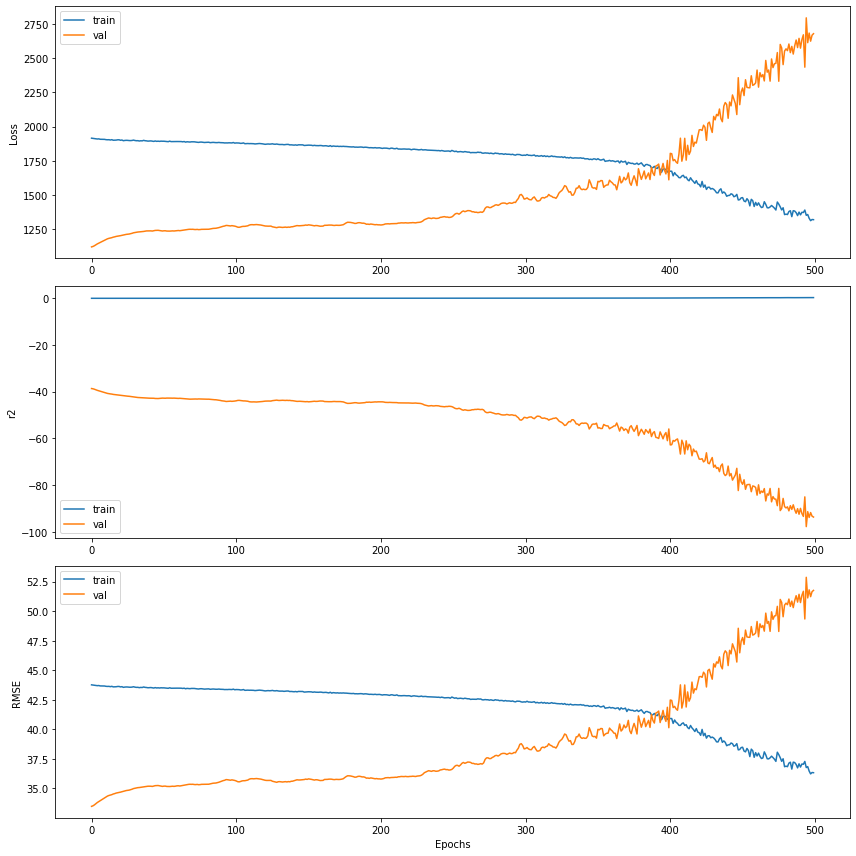

45/45 - 0s - 113ms/epoch - 3ms/step


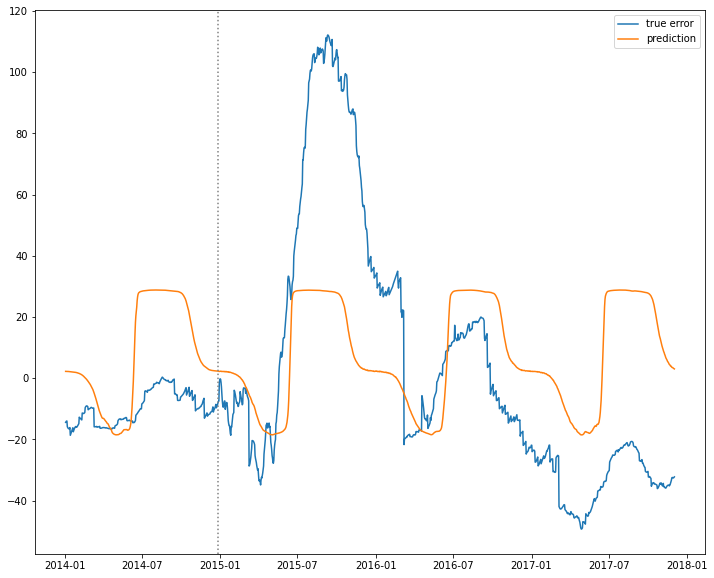

loss : 469.7757568359375
r_square : -15.683616638183594
root_mean_squared_error : 21.6743106842041


In [69]:
# train model and predict 
lauch_train(model, ds2, epochs=500, batch_size=128, print_arch_model=True, print_history=True)

-------

## LSTM with many input variables

In [52]:
def LSTM_model_S(timesteps, features, units=30, reg=None):
    
    model = Sequential()
    model.add(LSTM(units = units, return_sequences = False, input_shape = (timesteps, features), dropout=.1,
                    recurrent_dropout=.1, kernel_regularizer=reg, recurrent_regularizer=reg))
    model.add(Dropout(0.1))

#     model.add(LSTM(units = units, return_sequences = True))
#     model.add(Dropout(0.1))

#     model.add(LSTM(units = units))
#     model.add(Dropout(0.1))   
    
    model.add(Dense(units = 1))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)  # 3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model

In [53]:
def LSTM_model_stateful(timesteps, features, units=30, n_batch=128):
    
    model = Sequential()
    model.add(LSTM(units = units, return_sequences = False, batch_input_shape = (n_batch, timesteps, features), dropout=.1,
                    recurrent_dropout=.1, stateful=True))
    model.add(Dropout(0.1))

#     model.add(LSTM(units = units, return_sequences = True))
#     model.add(Dropout(0.1))

#     model.add(LSTM(units = units))
#     model.add(Dropout(0.1))   
    
    model.add(Dense(units = 1))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)  # 3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model

In [71]:
np.where(np.array(totlabels)=='hsnw00 t+0 PC0')

(array([104]),)

In [276]:
totlabels

['Xe t+1 PC0',
 'Xe t+1 PC1',
 'Xe t+1 PC2',
 'Xe t+1 PC3',
 'Xe t+2 PC0',
 'Xe t+2 PC1',
 'Xe t+2 PC2',
 'Xe t+2 PC3',
 'Xe t+9 PC0',
 'Xe t+9 PC1',
 'Xe t+9 PC2',
 'Xe t+9 PC3',
 'Xe t+16 PC0',
 'Xe t+16 PC1',
 'Xe t+16 PC2',
 'Xe t+16 PC3',
 'Xe t+23 PC0',
 'Xe t+23 PC1',
 'Xe t+23 PC2',
 'Xe t+23 PC3',
 'Xe t+30 PC0',
 'Xe t+30 PC1',
 'Xe t+30 PC2',
 'Xe t+30 PC3',
 'SITf t+0 PC0',
 'SITf t+0 PC1',
 'SITf t+0 PC2',
 'SITf t+0 PC3',
 'SITf t+1 PC0',
 'SITf t+1 PC1',
 'SITf t+1 PC2',
 'SITf t+1 PC3',
 'airtmp t+0 PC0',
 'airtmp t+0 PC1',
 'airtmp t+0 PC2',
 'airtmp t+0 PC3',
 'airtmp t+1 PC0',
 'airtmp t+1 PC1',
 'airtmp t+1 PC2',
 'airtmp t+1 PC3',
 'mslprs t+0 PC0',
 'mslprs t+0 PC1',
 'mslprs t+0 PC2',
 'mslprs t+0 PC3',
 'mslprs t+1 PC0',
 'mslprs t+1 PC1',
 'mslprs t+1 PC2',
 'mslprs t+1 PC3',
 'vapmix t+0 PC0',
 'vapmix t+0 PC1',
 'vapmix t+0 PC2',
 'vapmix t+0 PC3',
 'vapmix t+1 PC0',
 'vapmix t+1 PC1',
 'vapmix t+1 PC2',
 'vapmix t+1 PC3',
 'precip t+0 PC0',
 'precip t+0 PC1'

In [54]:
np.where('t+0' in np.array(totlabels))

(array([], dtype=int64),)

In [55]:
# get index most imp
# most imp for PC0
most_imp = ['SITf t+0 PC0', 'hsnw00 t+0 PC1', 'SITf t+0 PC1', 'hsnw00 t+0 PC3', 'SITf t+0 PC2',
                      'hsnw00 t+0 PC1', 'airtmp t+0 PC1', 'hsnw00 t+0 PC2', 'airtmp t+0 PC3',
                      'hsnw00 t+0 PC3'] + \
            ['mslprs t+0', 'wndewd t+0', 'precip t+0']

most_imp = ['SITf t+0 PC0', 'hsnw00 t+0 PC1', 'airtmp t+0 PC1'] #  'mslprs t+0'] # , 'airtmp t+0']
most_imp = ['SITf t+0', 'hsnw00 t+0', 'airtmp t+0', 'mslprs t+0', 'precip t+0','wndewd t+0'] # , 'airtmp t+0']


indexes = []

for mi in most_imp:
    for idx, lb in enumerate(totlabels):
        if mi in lb:
            indexes.append(idx)
        


In [56]:
indexes;

In [57]:
H = [0,7,14,21,28, 35, 42]

In [58]:
ds3 = build_dataset_1pt(X, y, chrono, train_p=3/4, times=H)

In [59]:
# select only hsnw00 t+0 PC0'
ds3[0]['Xtrain']= ds3[0]['Xtrain'][:,:, indexes]
ds3[0]['Xtest']= ds3[0]['Xtest'][:,:, indexes]

In [60]:
ds3[0]["Xtrain"].shape

(1063, 7, 29)

In [61]:
# rescale for data - OTHER METHOD
ds3[0]["Xtrain"], ds3[0]["Xtest"] = scale_data_var(ds3[0]["Xtrain"], ds3[0]["Xtest"])

In [62]:
# only PC0
ds3[0]['ytrain'] = ds3[0]['ytrain'][:,0]# .shape
ds3[0]['ytest'] = ds3[0]['ytest'][:,0]# .shape

In [63]:
# format (times, history, features)
ds3[0]['Xtrain'].shape

(1063, 7, 29)

In [64]:
ds3[0]['ytrain'].shape

(1063,)

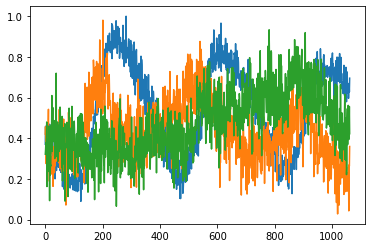

In [65]:
plt.plot(ds3[0]['Xtrain'][:,0,0])
plt.plot(ds3[0]['Xtrain'][:,0,1])
plt.plot(ds3[0]['Xtrain'][:,0,2])

-------

In [214]:
# model3 = LSTM_model_S(ds3[0]['Xtrain'].shape[1], ds3[0]['Xtrain'].shape[2], units=100)
model3 = LSTM_model_S(ds3[0]['Xtrain'].shape[1], ds3[0]['Xtrain'].shape[2], units=3)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 3)                 336       
                                                                 
 dropout_23 (Dropout)        (None, 3)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 4         
                                                                 
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________


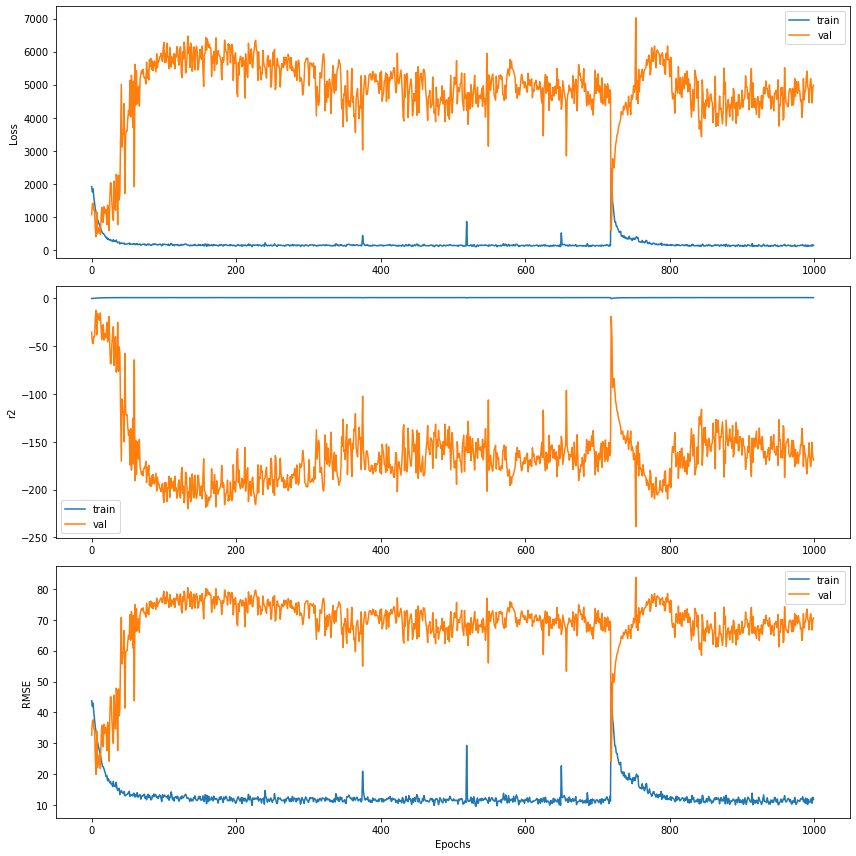

45/45 - 1s - 1s/epoch - 23ms/step


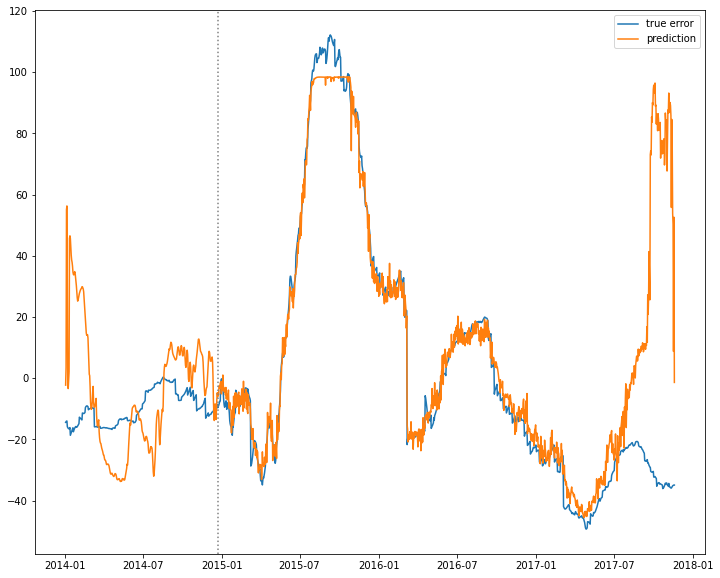

loss : 428.7244567871094
r_square : -14.101806640625
root_mean_squared_error : 20.70566177368164


In [215]:
# train model and predict 
# lauch_train(model3, ds3, epochs=200, batch_size=128, print_arch_model=True, print_history=True)
lauch_train(model3, ds3, epochs=1000, batch_size=4, print_arch_model=True, print_history=True)

In [220]:
model4 = LSTM_model_S(ds3[0]['Xtrain'].shape[1], ds3[0]['Xtrain'].shape[2], units=8)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 8)                 1056      
                                                                 
 dropout_24 (Dropout)        (None, 8)                 0         
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0
_________________________________________________________________


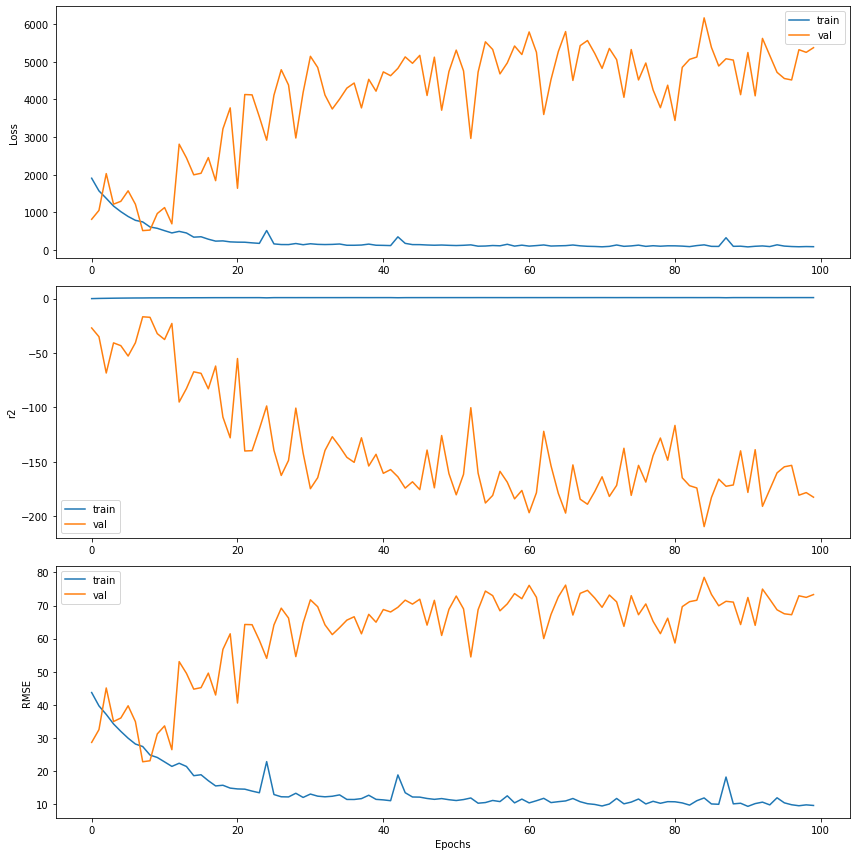

45/45 - 0s - 359ms/epoch - 8ms/step


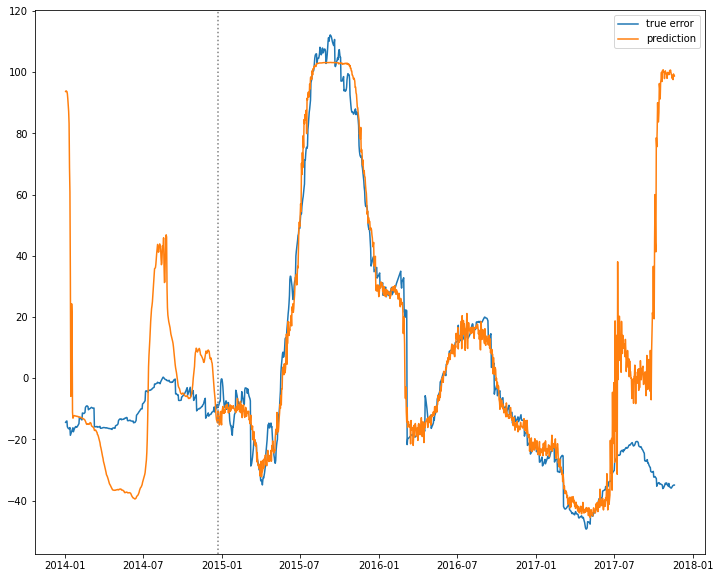

loss : 714.771728515625
r_square : -24.177812576293945
root_mean_squared_error : 26.735214233398438


In [221]:
# train model and predict 
# lauch_train(model3, ds3, epochs=200, batch_size=128, print_arch_model=True, print_history=True)
lauch_train(model4, ds3, epochs=100, batch_size=8, print_arch_model=True, print_history=True)

-------

### with L1L2 regularization

In [66]:
# L1L2 = []
from keras.regularizers import L1L2

regularizers = [L1L2(l1=0.01, l2=0), L1L2(l1=0, l2=0.01), L1L2(l1=0.03, l2=0.03)]

In [67]:
# model4 = LSTM_model_S(ds3[0]['Xtrain'].shape[1], ds3[0]['Xtrain'].shape[2], units=8, reg=regularizers[2])
model4 = LSTM_model(ds3[0]['Xtrain'].shape[1], ds3[0]['Xtrain'].shape[2], units=8, reg=regularizers[2])

2022-09-15 10:24:11.524246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-15 10:24:11.551443: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-15 10:24:11.563906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-09-15 10:24:11.615858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# train model and predict 
# lauch_train(model3, ds3, epochs=200, batch_size=128, print_arch_model=True, print_history=True)
lauch_train(model4, ds3, epochs=1000, batch_size=8, print_arch_model=True, print_history=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 8)              1216      
                                                                 
 dropout (Dropout)           (None, 7, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 8)              544       
                                                                 
 dropout_1 (Dropout)         (None, 7, 8)              0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9

-------

Epochs number higher !

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 8)                 1216      
                                                                 
 dropout_37 (Dropout)        (None, 8)                 0         
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


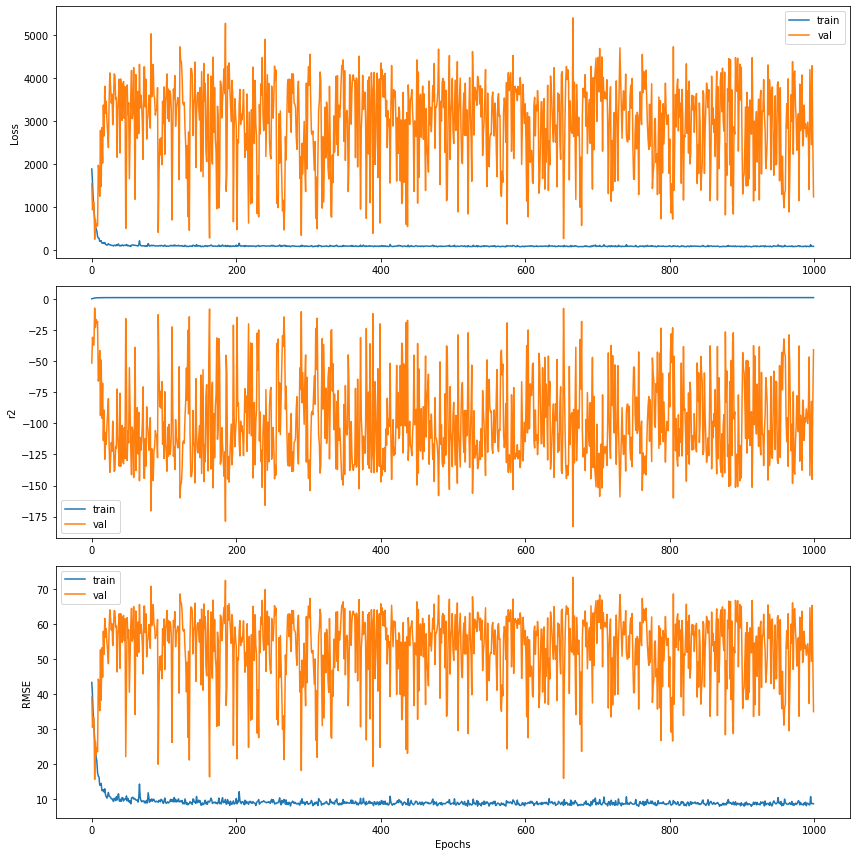

45/45 - 3s - 3s/epoch - 64ms/step


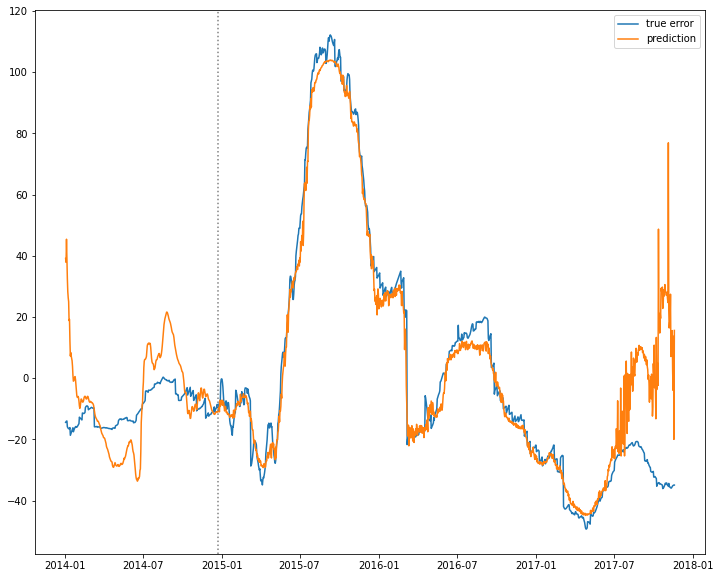

loss : 187.601806640625
r_square : -5.265065670013428
root_mean_squared_error : 13.336365699768066


In [288]:
# train model and predict 
# lauch_train(model3, ds3, epochs=200, batch_size=128, print_arch_model=True, print_history=True)

# reg = 0.1 0.1
lauch_train(model4, ds3, epochs=1000, batch_size=4, print_arch_model=True, print_history=True)

-------

## Conv1D tries
// with many input variables

In [136]:
def CNN_model(timesteps, features):
    
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', input_shape=(timesteps, features)))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(units = 1))

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model



In [290]:
from keras.models import Model

def CNN_multihead_model(timesteps, features, n_output, reg=None):
    
  # head 1
    inputs1 = Input(shape=(timesteps, features))
    conv1 = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=reg)(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(timesteps, features))
    conv2 = Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', kernel_regularizer=reg)(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(timesteps, features))
    conv3 = Conv1D(filters=256, kernel_size=11, padding='same', activation='relu', kernel_regularizer=reg)(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_output)(dense1)  # , activation='softmax'
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])

    
    return model



In [254]:
H = [0,7,14,21,28, 35, 42, 49, 56, 63, 70, 77]

In [276]:
# dataset format

ds = build_dataset_1pt(X, y, chrono, train_p=3/4, times=H) # H


In [277]:
# get index most imp
# most imp for PC0
# most_imp = ['SITf t+0 PC0', 'hsnw00 t+0 PC1', 'SITf t+0 PC1', 'hsnw00 t+0 PC3', 'SITf t+0 PC2',
#                       'hsnw00 t+0 PC1', 'airtmp t+0 PC1', 'hsnw00 t+0 PC2', 'airtmp t+0 PC3',
#                       'hsnw00 t+0 PC3'] + \
#             ['mslprs t+0', 'wndewd t+0', 'precip t+0']

# most_imp = ['SITf t+0 PC0', 'hsnw00 t+0 PC1', 'airtmp t+0 PC1'] #  'mslprs t+0'] # , 'airtmp t+0']
most_imp = ['SITf t+0', 'hsnw00 t+0', 'airtmp t+0', 'mslprs t+0', 'precip t+0','wndewd t+0'] # , 'airtmp t+0']

indexes = []

for mi in most_imp:
    for idx, lb in enumerate(totlabels):
        if mi in lb:
            indexes.append(idx)
        


In [332]:
var_name = np.array(full_label)[indexes]

In [278]:
ds[0]['Xtrain'].shape

(1037, 12, 156)

In [279]:
ds[0]['Xtest'].shape

(346, 12, 156)

In [280]:
# select only hsnw00 t+0 PC0'
ds[0]['Xtrain'] = ds[0]['Xtrain'][:,:, indexes]
ds[0]['Xtest'] = ds[0]['Xtest'][:,:, indexes]

In [281]:
# only PC0
ds[0]['ytrain'] = ds[0]['ytrain'][:,0]# .shape
ds[0]['ytest'] = ds[0]['ytest'][:,0]# .shape

In [282]:
ds[0]['Xtrain'].shape

(1037, 12, 29)

In [283]:
ds[0]['ytrain'].shape

(1037,)

In [284]:
# rescale for data - OTHER METHOD
ds[0]["Xtrain"], ds[0]["Xtest"] = scale_data_var(ds[0]["Xtrain"], ds[0]["Xtest"])

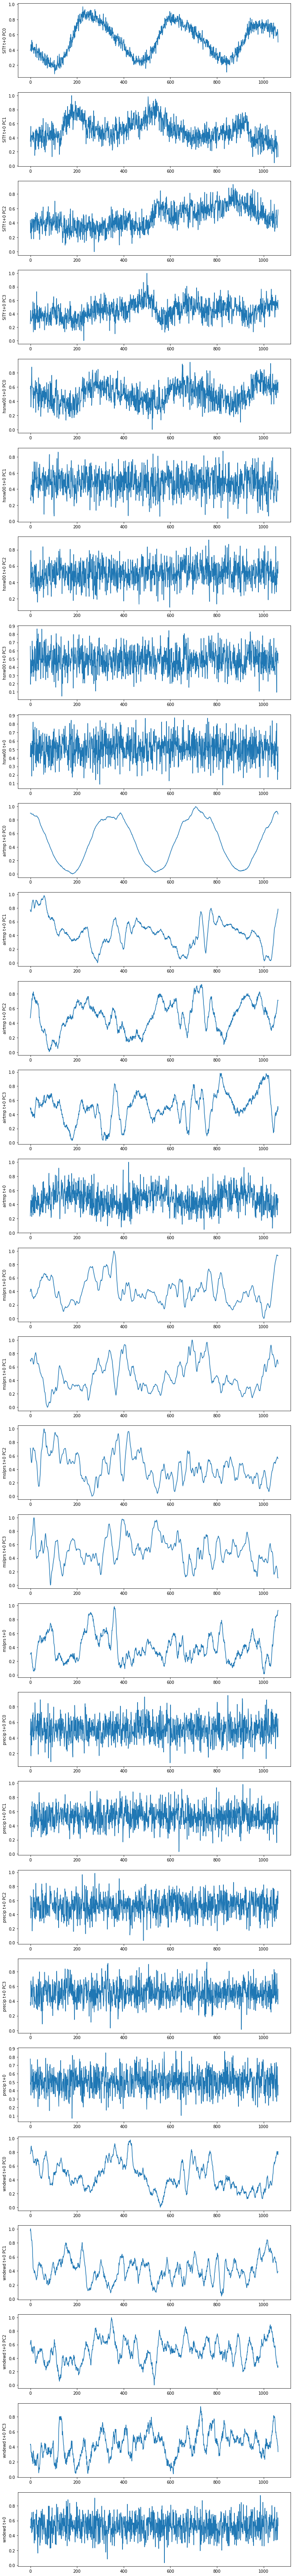

In [139]:
nvar = ds[0]['Xtrain'].shape[2]
fig, axes = plt.subplots(nvar, 1, figsize=(12,4*nvar))
for idx, ax in enumerate(axes.flatten()):
    ax.plot(ds[0]['Xtrain'][:,0,idx])
    ax.set_ylabel(full_label[indexes[idx]])

----

In [137]:
model = CNN_model(ds[0]['Xtrain'].shape[1], ds[0]['Xtrain'].shape[2])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 7, 256)            37376     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 1, 256)            0         
                                                                 
 flatten_7 (Flatten)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 37,633
Trainable params: 37,633
Non-trainable params: 0
__________________________________________________

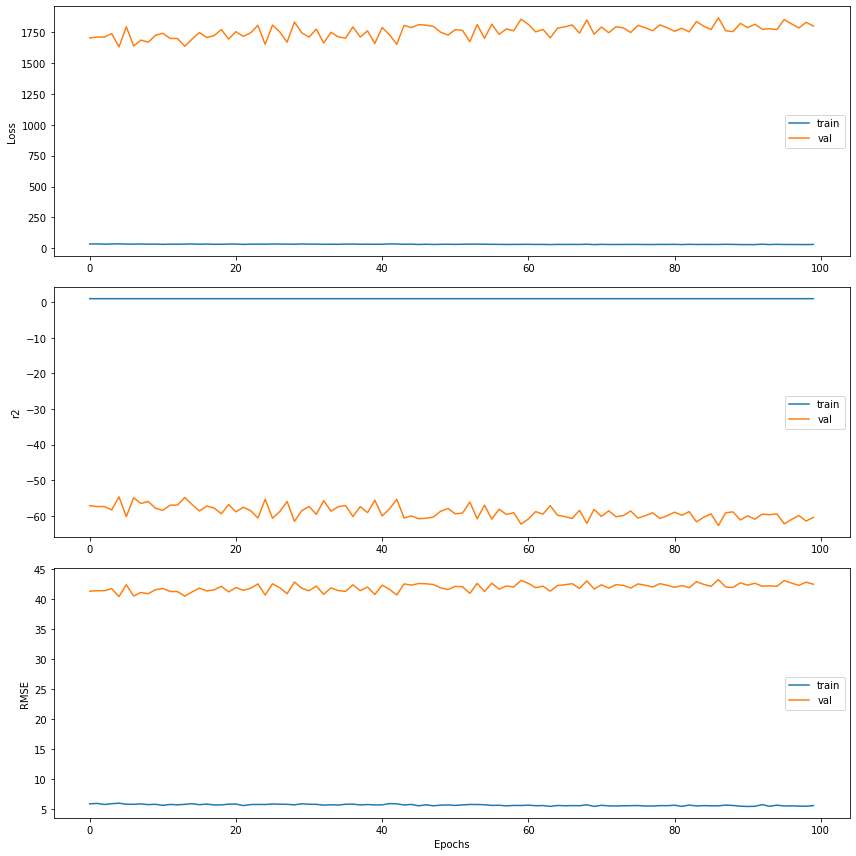

45/45 - 0s - 61ms/epoch - 1ms/step


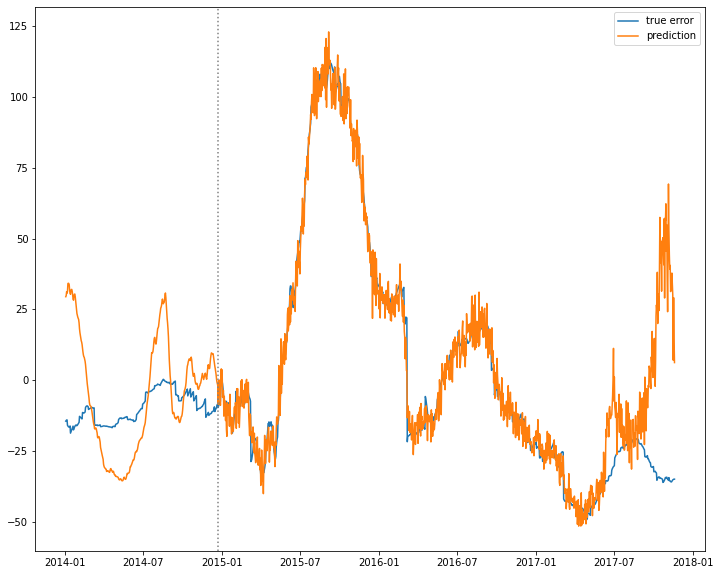

loss : 385.8010559082031
r_square : -12.58983039855957
root_mean_squared_error : 19.64181900024414


In [141]:
lauch_train(model, ds, epochs=100, batch_size=128, print_arch_model=True, print_history=True)

----

In [228]:
n_output = ds[0]['ytrain'].shape[0]
model_mh = CNN_multihead_model(ds[0]['Xtrain'].shape[1], ds[0]['Xtrain'].shape[2], n_output=1)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 12, 29)]     0           []                               
                                                                                                  
 input_65 (InputLayer)          [(None, 12, 29)]     0           []                               
                                                                                                  
 input_66 (InputLayer)          [(None, 12, 29)]     0           []                               
                                                                                                  
 conv1d_71 (Conv1D)             (None, 12, 256)      163584      ['input_64[0][0]']               
                                                                                           

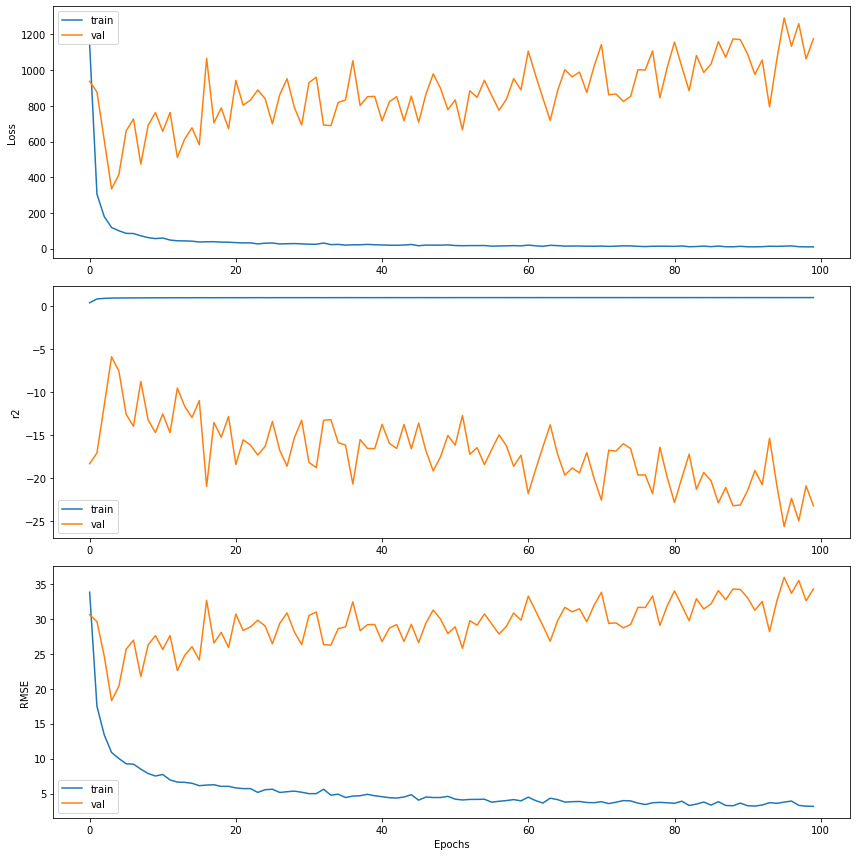

44/44 [==============================] - 1s 2ms/step


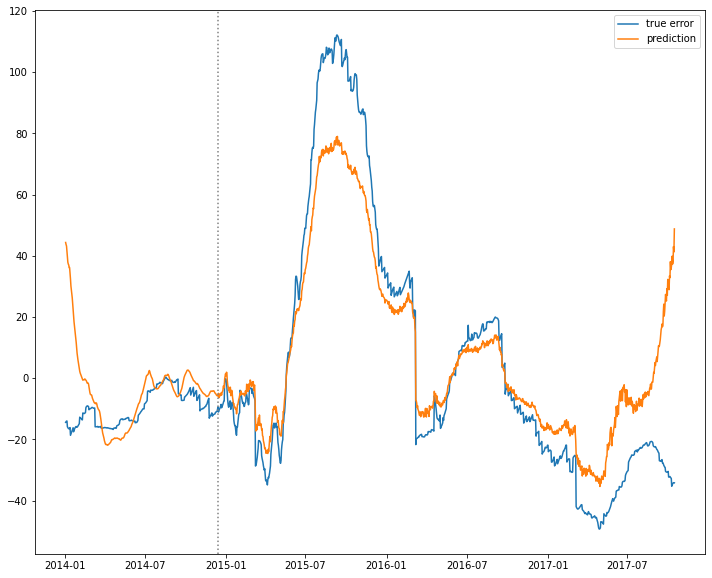

loss : 194.0355682373047
r_square : -5.66461181640625
root_mean_squared_error : 13.929664611816406


In [229]:
fit_cnn_mh(model_mh, ds, epochs=100, batch_size=4, print_arch_model=True, print_history=True)

----

In [291]:
# L1L2 = []
from keras.regularizers import L1L2

regularizers = [L1L2(l1=0.01, l2=0), L1L2(l1=0, l2=0.01), L1L2(l1=0.03, l2=0.03)]

In [293]:
n_output = ds[0]['ytrain'].shape[0]
model_mh_reg = CNN_multihead_model(ds[0]['Xtrain'].shape[1], ds[0]['Xtrain'].shape[2], n_output=1, reg=regularizers[2])

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_67 (InputLayer)          [(None, 12, 29)]     0           []                               
                                                                                                  
 input_68 (InputLayer)          [(None, 12, 29)]     0           []                               
                                                                                                  
 input_69 (InputLayer)          [(None, 12, 29)]     0           []                               
                                                                                                  
 conv1d_74 (Conv1D)             (None, 12, 256)      22528       ['input_67[0][0]']               
                                                                                           

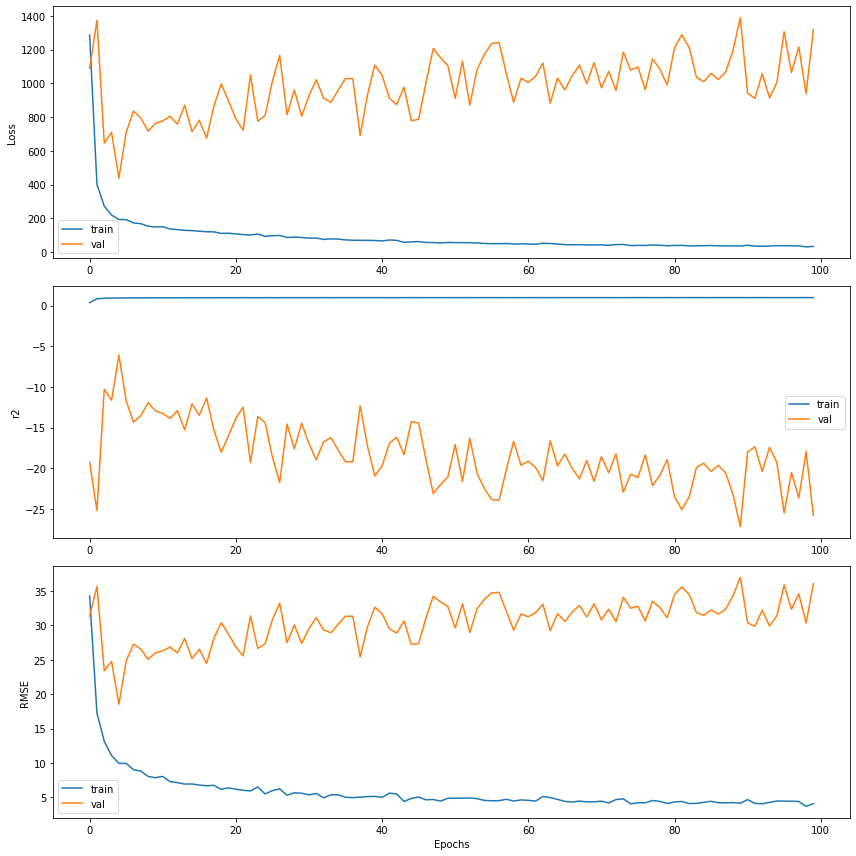

44/44 [==============================] - 1s 2ms/step


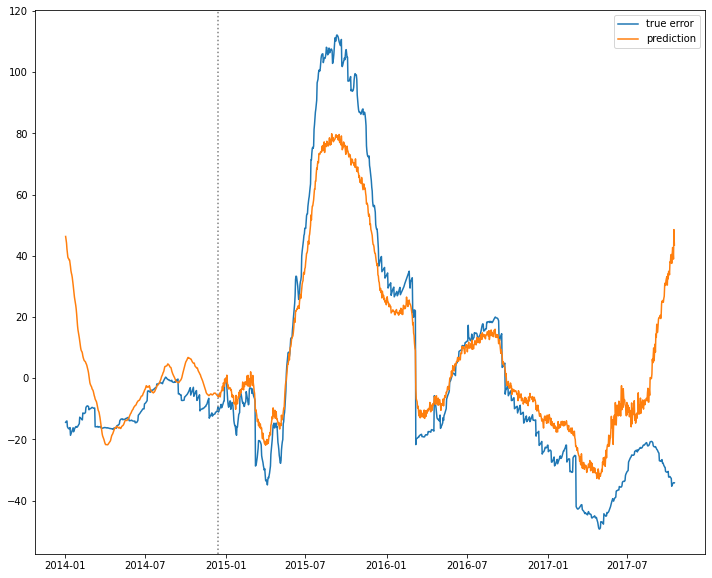

loss : 275.6444091796875
r_square : -7.878198623657227
root_mean_squared_error : 16.077394485473633


In [294]:
fit_cnn_mh(model_mh_reg, ds, epochs=100, batch_size=4, print_arch_model=True, print_history=True)

In [ ]:
import shap

In [300]:
# init the JS visualization code
shap.initjs()

In [311]:
# DEEP EXPLAINER - works with 3D dataset

explainer = shap.DeepExplainer(model_mh_reg, [ds[0]['Xtrain']]*3)
shap_values = explainer.shap_values([ds[0]['Xtest']]*3)

# shap.force_plot(explainer.expected_value[0], shap_value[0], ds[0]['Xtest'], link='logit')


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [321]:
ds[0]['Xtest'].shape

(346, 12, 29)

In [327]:
len(shap_values[0][0])

346

In [388]:
shap_values[0][:][0].shape

(346, 12, 29)

In [402]:
# mean shap values over History
mean_shap = np.mean(shap_values[0][:][0],axis=(1))

In [403]:
mean_shap

array([[-0.14378295, -0.06584565,  0.09213055, ...,  0.03758953,
         0.03769833,  0.00082917],
       [-0.14984028, -0.06695099,  0.0921738 , ...,  0.03139047,
         0.03812666,  0.00083059],
       [-0.15418073, -0.06745249,  0.09161027, ...,  0.02098768,
         0.04009159,  0.00084842],
       ...,
       [-0.13820344, -0.05944919,  0.10773385, ..., -0.01192479,
         0.04575796,  0.00094297],
       [-0.13849589, -0.05812654,  0.10703714, ..., -0.01567581,
         0.0499735 ,  0.00092474],
       [-0.14074736, -0.05697441,  0.10733193, ..., -0.01947959,
         0.05880303,  0.00091579]])

In [408]:
# shap values for History = 0
reshape_shap = (shap_values[0][:][0])[:,0]

In [342]:
shap_values[0][0][0][0]

array([-3.52607196e-02, -1.01332300e-01,  9.26173298e-02, -7.86698894e-02,
        1.29776699e-02,  2.41026128e-03,  2.99753096e-03,  3.98747934e-03,
        1.86373091e-03,  4.57436954e-02,  1.56115532e-01,  4.32708768e-01,
        3.17545161e-01,  3.34488165e-02,  3.58169402e-01, -2.18911459e-01,
       -1.67457538e-02, -4.90268420e-01,  1.48489049e-01,  9.66990436e-04,
        6.18636993e-04,  1.91087932e-04,  6.53277705e-04,  3.19797680e-03,
        2.68779380e-01, -5.06492310e-02, -3.08464089e-02,  8.61594540e-02,
        2.14308435e-03])

In [343]:
var_name

array(['SITf t+0 PC0', 'SITf t+0 PC1', 'SITf t+0 PC2', 'SITf t+0 PC3',
       'hsnw00 t+0 PC0', 'hsnw00 t+0 PC1', 'hsnw00 t+0 PC2',
       'hsnw00 t+0 PC3', 'hsnw00 t+0', 'airtmp t+0 PC0', 'airtmp t+0 PC1',
       'airtmp t+0 PC2', 'airtmp t+0 PC3', 'airtmp t+0', 'mslprs t+0 PC0',
       'mslprs t+0 PC1', 'mslprs t+0 PC2', 'mslprs t+0 PC3', 'mslprs t+0',
       'precip t+0 PC0', 'precip t+0 PC1', 'precip t+0 PC2',
       'precip t+0 PC3', 'precip t+0', 'wndewd t+0 PC0', 'wndewd t+0 PC1',
       'wndewd t+0 PC2', 'wndewd t+0 PC3', 'wndewd t+0'], dtype='<U14')

In [376]:
explainer.expected_value.numpy()[0]

9.04607

In [378]:
shap.force_plot(explainer.expected_value.numpy()[0], shap_values[0][0][0][0], var_name)

In [404]:
shap.force_plot(explainer.expected_value.numpy()[0], mean_shap, var_name)

In [412]:
# shap.force_plot(explainer.expected_value.numpy()[0], reshape_shap, var_name)
shap.force_plot(explainer.expected_value.numpy()[0], (shap_values[0][:][0])[:,3], var_name)

----

In [272]:
# add noise to input data to see how outputs change

def add_noise(dataset):
    
    Xtrain = dataset[0]['Xtrain'].copy()
    dataset[0]['Xtrain'] = Xtrain + np.random.normal(0, np.std(Xtrain) / 5, Xtrain.shape)

    
    Xtest = dataset[0]['Xtest'].copy()
    dataset[0]['Xtest'] = Xtest + np.random.normal(0, np.std(Xtest) / 5, Xtest.shape)
    
    return dataset
    
    

44/44 [==============================] - 0s 2ms/step


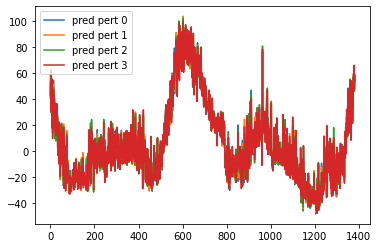

In [274]:
# seemed like a good idea but nothing fancy about the results
# more noise in the dataset = more noise in the prediction

ntest = 4

for i in range(ntest):
    ds2 = add_noise(ds.copy())
    yp = pred_cnn_mh(model_mh, ds2)
    plt.plot(yp, label=f'pred pert {i}')
    
    
plt.legend()

----

----

----

----

In [78]:
from src.modelling import model_ridge
from src.modelling import model_rf
from src.modelling import model_grdbst
from src.modelling import model_xgboost
# from src.modelling import model_lstm


from src.modelling import model_utils

ml_classes = [model_ridge, model_rf, model_grdbst, model_xgboost]  # , model_lstm]  # etc
ml_classes_name = ['model_ridge', 'model_rf', 'model_grdbst', 'model_xgboost']  # , 'model_lstm']

In [79]:
# to load a specific model
# m1 = model_grdbst.ModelML(nfeat)
# m1.load('path/to/model/model_grdbst.joblib')  # or .save ?

In [80]:
# pick the corresponding machine learning model
ml_idx = [i for i, cl in enumerate(ml_classes_name) if ml_model in cl][0]

In [81]:
m1 = ml_classes[ml_idx].ModelML(nfeat, ntest, ntrain, totlabels, rootdir, ml_dir, fig_dir)

m1.generate_model()

In [82]:
# m1.dict_grid

In [83]:
# same parameters for all PCA
# m1.gridCV(param_grid, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)

In [84]:
# DIFFERENT PARAMETERS FOR EACH PCA
m1.improved_gridCV(param.param_opt, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)


In [85]:
m1.input_dico = input_dd.dico  # input_dico
m1.full_label = full_label

In [86]:
input_dd.dico;

----

In [87]:
m1.dico_param

{'pc0': {'xgbregressor__learning_rate': [0.554],
  'xgbregressor__max_depth': [2],
  'xgbregressor__colsample_bytree': [0.45686],
  'xgbregressor__n_estimators': [103],
  'xgbregressor__subsample': [0.1],
  'xgbregressor__booster': ['dart'],
  'xgbregressor__sample_type': ['uniform'],
  'xgbregressor__rate_drop': [0.1],
  'xgbregressor__skip_drop': [0.5],
  'xgbregressor__random_state': [0]},
 'pc1': {'xgbregressor__learning_rate': [0.333],
  'xgbregressor__max_depth': [8],
  'xgbregressor__colsample_bytree': [0.8],
  'xgbregressor__n_estimators': [200],
  'xgbregressor__subsample': [0.27],
  'xgbregressor__random_state': [0],
  'xgbregressor__booster': ['dart'],
  'xgbregressor__sample_type': ['uniform'],
  'xgbregressor__rate_drop': [0.1],
  'xgbregressor__skip_drop': [0.5]},
 'pc2': {'xgbregressor__learning_rate': [0.62],
  'xgbregressor__max_depth': [3],
  'xgbregressor__colsample_bytree': [0.8],
  'xgbregressor__n_estimators': [260],
  'xgbregressor__subsample': [0.32],
  'xgbregr

## FIRST FIT - LOOP FIT

In [111]:
# m1.dict_grid['pc0'].best_estimator_['randomforestregressor'].n_estimators_
# il ny a pas de arg: .n_estimators_ in randomforest

In [88]:
m1.improved_fit(Xtrain, ytrain)

pc0 fit with 472 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+2 PC0'
 'Xe t+2 PC1' 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+3 PC0' 'Xe t+3 PC1'
 'Xe t+3 PC2' 'Xe t+3 PC3' 'Xe t+4 PC0' 'Xe t+4 PC1' 'Xe t+4 PC2'
 'Xe t+4 PC3' 'Xe t+7 PC0' 'Xe t+7 PC1' 'Xe t+7 PC2' 'Xe t+7 PC3'
 'Xe t+10 PC0' 'Xe t+10 PC1' 'Xe t+10 PC2' 'Xe t+10 PC3' 'Xe t+13 PC0'
 'Xe t+13 PC1' 'Xe t+13 PC2' 'Xe t+13 PC3' 'Xe t+16 PC0' 'Xe t+16 PC1'
 'Xe t+16 PC2' 'Xe t+16 PC3' 'Xe t+19 PC0' 'Xe t+19 PC1' 'Xe t+19 PC2'
 'Xe t+19 PC3' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2' 'SITf t+1 PC3'
 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2' 'SITf t+2 PC3'
 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2' 'SITf t+3 PC3'
 'airtmp t+0 PC0' 'airtmp t+0 PC1' 'airtmp t+0 PC2' 'airtmp t+0 PC3'
 'airtmp t+1 PC0' 'airtmp t+1 PC1' 'airtmp t+1 PC2' 'airtmp t+1 PC3'
 'airtmp t+2 PC0' 'airtmp t+2 PC1' 'airtmp t+2 PC2' 'airtmp t+2 PC3'
 'airtmp t+3 PC0' 'airtmp t+3 P

pc1 fit with 472 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+2 PC0'
 'Xe t+2 PC1' 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+3 PC0' 'Xe t+3 PC1'
 'Xe t+3 PC2' 'Xe t+3 PC3' 'Xe t+4 PC0' 'Xe t+4 PC1' 'Xe t+4 PC2'
 'Xe t+4 PC3' 'Xe t+7 PC0' 'Xe t+7 PC1' 'Xe t+7 PC2' 'Xe t+7 PC3'
 'Xe t+10 PC0' 'Xe t+10 PC1' 'Xe t+10 PC2' 'Xe t+10 PC3' 'Xe t+13 PC0'
 'Xe t+13 PC1' 'Xe t+13 PC2' 'Xe t+13 PC3' 'Xe t+16 PC0' 'Xe t+16 PC1'
 'Xe t+16 PC2' 'Xe t+16 PC3' 'Xe t+19 PC0' 'Xe t+19 PC1' 'Xe t+19 PC2'
 'Xe t+19 PC3' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2' 'SITf t+1 PC3'
 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2' 'SITf t+2 PC3'
 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2' 'SITf t+3 PC3'
 'airtmp t+0 PC0' 'airtmp t+0 PC1' 'airtmp t+0 PC2' 'airtmp t+0 PC3'
 'airtmp t+1 PC0' 'airtmp t+1 PC1' 'airtmp t+1 PC2' 'airtmp t+1 PC3'
 'airtmp t+2 PC0' 'airtmp t+2 PC1' 'airtmp t+2 PC2' 'airtmp t+2 PC3'
 'airtmp t+3 PC0' 'airtmp t+3 P

pc2 fit with 472 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+2 PC0'
 'Xe t+2 PC1' 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+3 PC0' 'Xe t+3 PC1'
 'Xe t+3 PC2' 'Xe t+3 PC3' 'Xe t+4 PC0' 'Xe t+4 PC1' 'Xe t+4 PC2'
 'Xe t+4 PC3' 'Xe t+7 PC0' 'Xe t+7 PC1' 'Xe t+7 PC2' 'Xe t+7 PC3'
 'Xe t+10 PC0' 'Xe t+10 PC1' 'Xe t+10 PC2' 'Xe t+10 PC3' 'Xe t+13 PC0'
 'Xe t+13 PC1' 'Xe t+13 PC2' 'Xe t+13 PC3' 'Xe t+16 PC0' 'Xe t+16 PC1'
 'Xe t+16 PC2' 'Xe t+16 PC3' 'Xe t+19 PC0' 'Xe t+19 PC1' 'Xe t+19 PC2'
 'Xe t+19 PC3' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2' 'SITf t+1 PC3'
 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2' 'SITf t+2 PC3'
 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2' 'SITf t+3 PC3'
 'airtmp t+0 PC0' 'airtmp t+0 PC1' 'airtmp t+0 PC2' 'airtmp t+0 PC3'
 'airtmp t+1 PC0' 'airtmp t+1 PC1' 'airtmp t+1 PC2' 'airtmp t+1 PC3'
 'airtmp t+2 PC0' 'airtmp t+2 PC1' 'airtmp t+2 PC2' 'airtmp t+2 PC3'
 'airtmp t+3 PC0' 'airtmp t+3 P

pc3 fit with 472 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+2 PC0'
 'Xe t+2 PC1' 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+3 PC0' 'Xe t+3 PC1'
 'Xe t+3 PC2' 'Xe t+3 PC3' 'Xe t+4 PC0' 'Xe t+4 PC1' 'Xe t+4 PC2'
 'Xe t+4 PC3' 'Xe t+7 PC0' 'Xe t+7 PC1' 'Xe t+7 PC2' 'Xe t+7 PC3'
 'Xe t+10 PC0' 'Xe t+10 PC1' 'Xe t+10 PC2' 'Xe t+10 PC3' 'Xe t+13 PC0'
 'Xe t+13 PC1' 'Xe t+13 PC2' 'Xe t+13 PC3' 'Xe t+16 PC0' 'Xe t+16 PC1'
 'Xe t+16 PC2' 'Xe t+16 PC3' 'Xe t+19 PC0' 'Xe t+19 PC1' 'Xe t+19 PC2'
 'Xe t+19 PC3' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2' 'SITf t+1 PC3'
 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2' 'SITf t+2 PC3'
 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2' 'SITf t+3 PC3'
 'airtmp t+0 PC0' 'airtmp t+0 PC1' 'airtmp t+0 PC2' 'airtmp t+0 PC3'
 'airtmp t+1 PC0' 'airtmp t+1 PC1' 'airtmp t+1 PC2' 'airtmp t+1 PC3'
 'airtmp t+2 PC0' 'airtmp t+2 PC1' 'airtmp t+2 PC2' 'airtmp t+2 PC3'
 'airtmp t+3 PC0' 'airtmp t+3 P

In [89]:
m1.improved_predict(X, y)

In [90]:
m1.nsplit = nsplit

In [70]:
# m1.compute_score_staged_nest()
# mdl_introspect.plot_cvscore_nboosting_iter(m1, showfig=True)

In [71]:
if bayesian_search and m1.type == 'grdbst':
    mdl_introspect.plot_optimizer_full(m1, showfig=True)    

#### Evaluation training phase

In [72]:
m1.eval_grid_cv()



 pc0
CV results:
{'mean_fit_time': array([90.55417287]),
 'mean_score_time': array([1.22191775]),
 'mean_test_score': array([0.17633712]),
 'param_xgbregressor__booster': masked_array(data=['dart'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__colsample_bytree': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__learning_rate': masked_array(data=[0.3],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__max_depth': masked_array(data=[5],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__n_estimators': masked_array(data=[125],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__random_state': masked_array(data=[0],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__rate_dr



 pc3
CV results:
{'mean_fit_time': array([15.28935719]),
 'mean_score_time': array([0.49852467]),
 'mean_test_score': array([0.80735428]),
 'param_xgbregressor__booster': masked_array(data=['dart'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__colsample_bytree': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__learning_rate': masked_array(data=[0.1],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__max_depth': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__n_estimators': masked_array(data=[50],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__random_state': masked_array(data=[0],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__rate_dro

### Recursive prediction

In [91]:
m1.set_target_history(H)

In [103]:
m1.recursive_prediction_multiple(X,y, init_test=True)

todo: put that in a script in src/modelling/recursive_prediction.py


KeyboardInterrupt: 

### Sequence recursive prediction

In [75]:
print('Score prediction recursive sequence')
m1.score_prediction()

Score prediction recursive sequence


 pc0
Mean Absolute Error:     32.214
R2:     -15.671
Root Mean Squared Error: 33.225


 pc1
Mean Absolute Error:     26.672
R2:     -2.883
Root Mean Squared Error: 29.216


 pc2
Mean Absolute Error:     8.065
R2:     -1.264
Root Mean Squared Error: 10.674


 pc3
Mean Absolute Error:     5.810
R2:     -0.088
Root Mean Squared Error: 7.436


### Visual evaluation of the prediction

In [97]:
from src.visualization import mdl_scatter_pred as msp
from src.visualization import mdl_non_recursive
from src.visualization import mdl_recursive
from src.visualization import mdl_recursive_sequence

In [95]:
m1.chrono = chrono

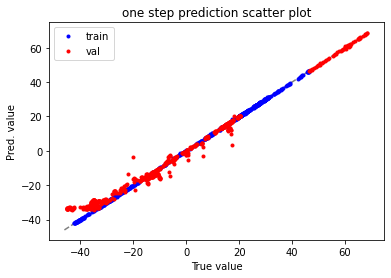

In [78]:
msp.draw_non_recursive(m1,1)

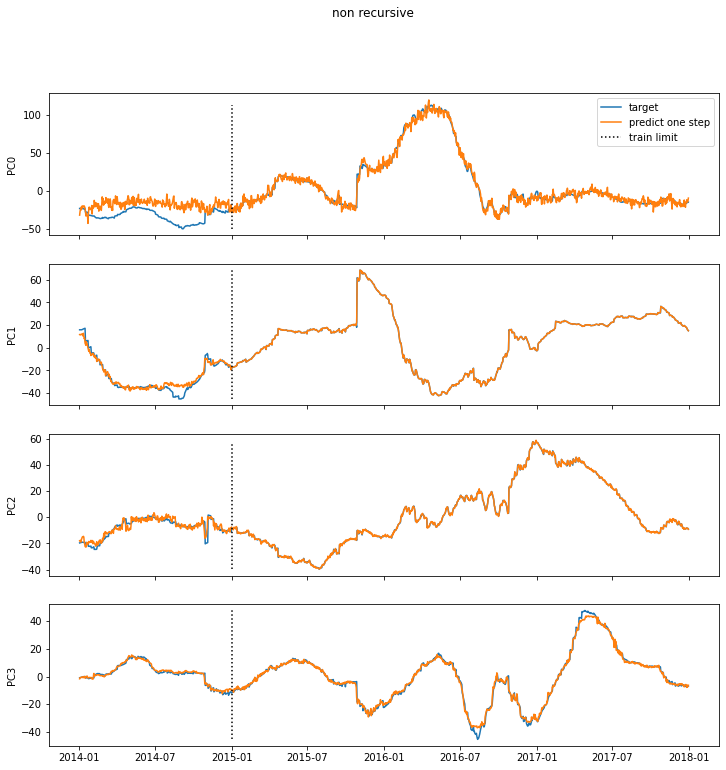

In [98]:
mdl_non_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=False)

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220909-104105/figures/ML_prediction_recursive.png


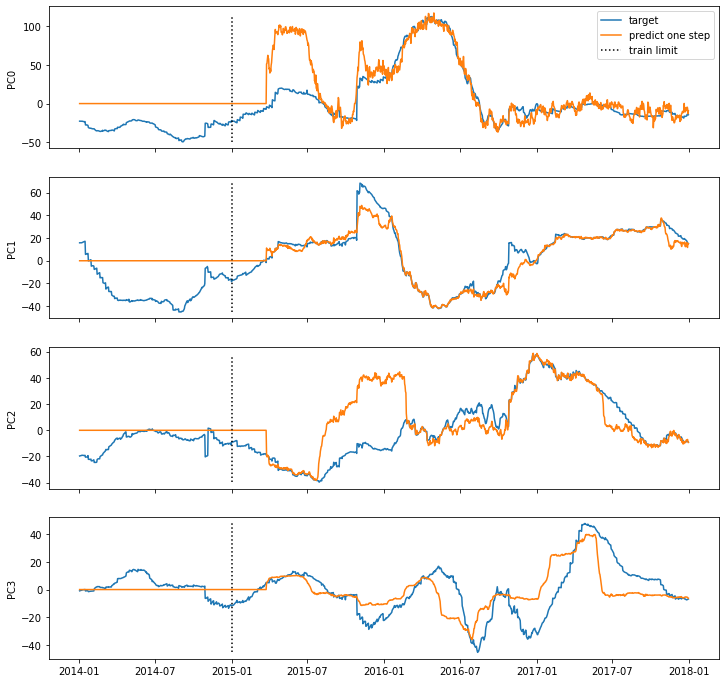

In [104]:
mdl_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True, showfig=True, force=True)

-----

In [81]:
from importlib import reload
reload(mdl_introspect);

In [82]:
mdl_recursive_sequence.draw_seq(m1, savefig=False)

Values predicted with following method: recursive.
            Use corresponding plotting function to visualize results.


In [83]:
mdl_recursive_sequence.draw(m1, savefig=True, odir= m1.rootdir + m1.fig_dir)

Values predicted with following method: recursive.
            Use corresponding plotting function to visualize results.


----

In [84]:
# mrs.draw_seq(m1, savefig=True)
mdl_recursive_sequence.draw(m1, max_plot=8, savefig=True)

Values predicted with following method: recursive.
            Use corresponding plotting function to visualize results.


In [85]:
reload(msp)

<module 'src.visualization.mdl_scatter_pred' from '/cluster/home/leoede/tardis/tardis-ml/src/visualization/mdl_scatter_pred.py'>

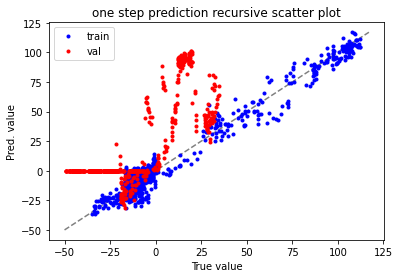

In [105]:
msp.draw_recursive(m1,0)

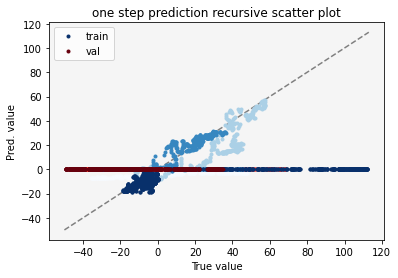

In [87]:
msp.draw_recursive_allfeat(m1, savefig=False)

------

### Evaluation variables importance

In [99]:
from src.visualization import visu_mdl_importance

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220909-104105/figures/importance_allPC.png


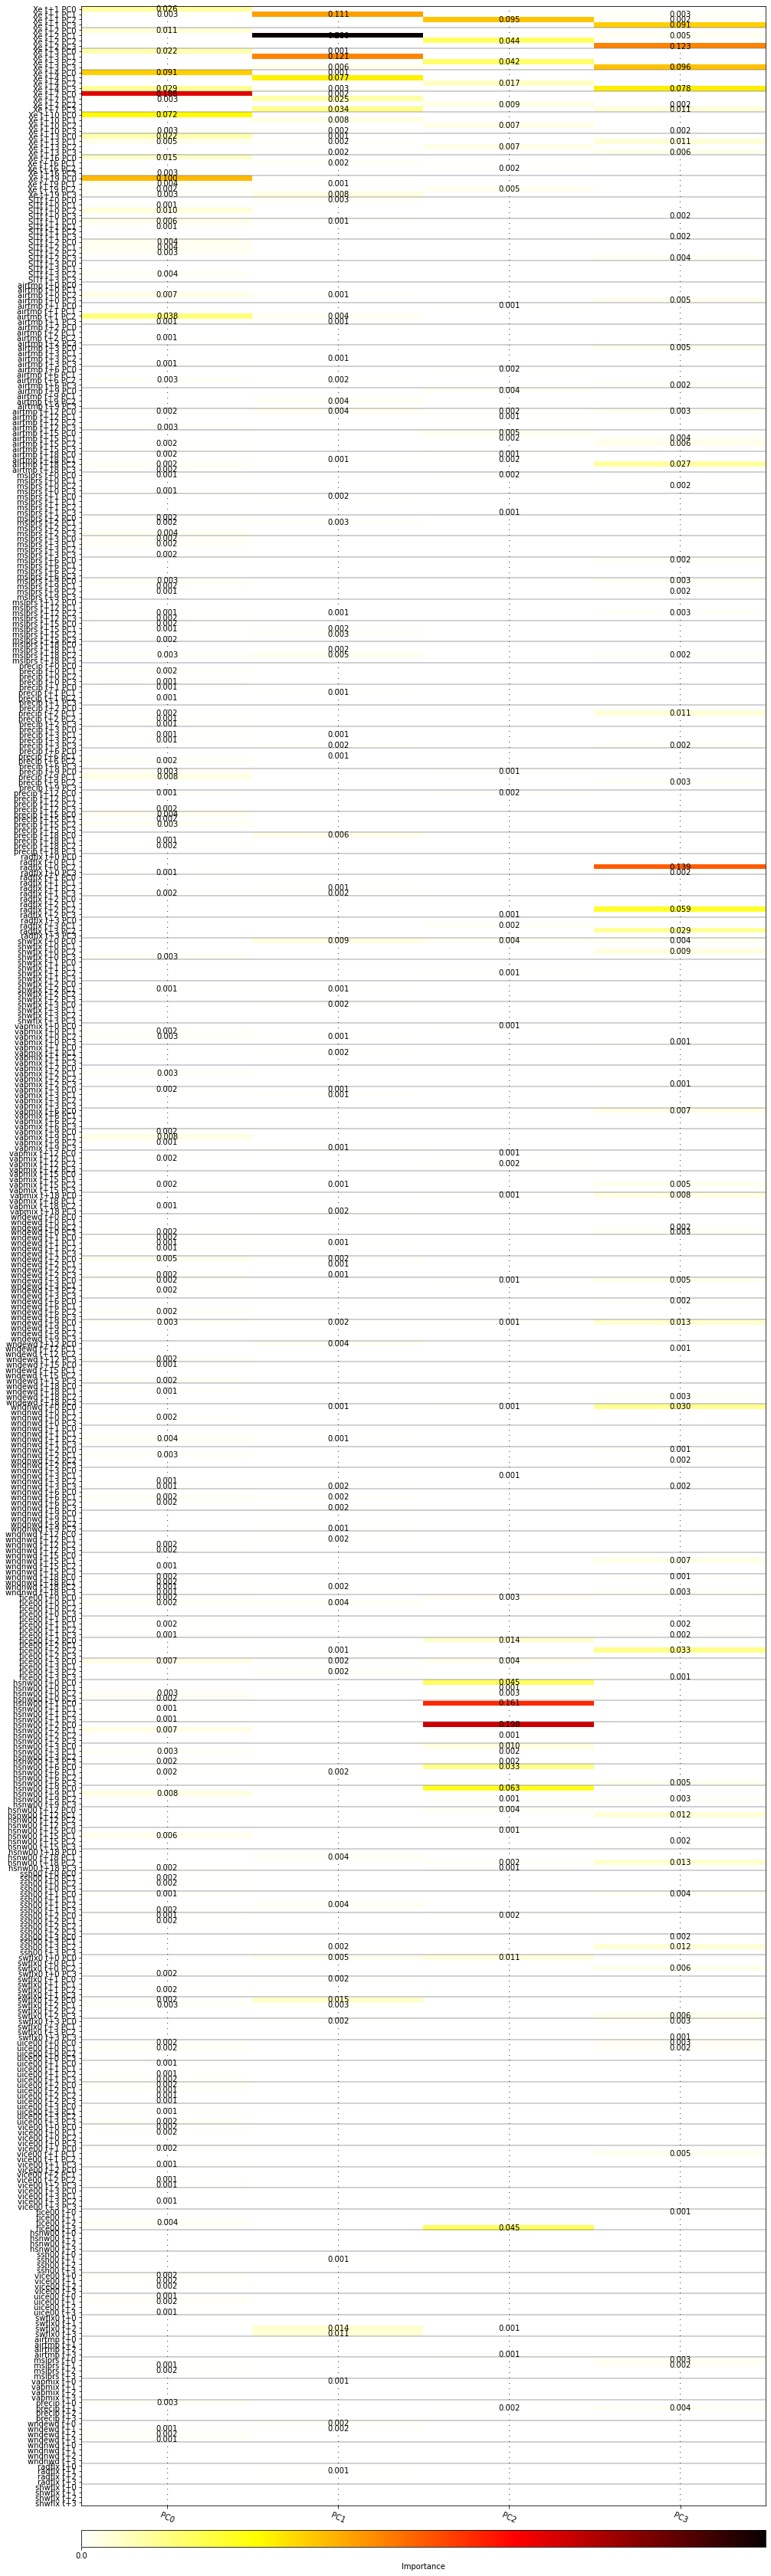

In [100]:
visu_mdl_importance.plot_importance_var_allpca(m1, savefig=True, showfig=True)

In [90]:
m1.dict_grid[f'pc{0}'].best_estimator_['xgbregressor'].feature_importances_

array([0.6813138 , 0.00334507, 0.00214315, 0.00217472, 0.25127113,
       0.00365854, 0.00218386, 0.00268985, 0.01197715, 0.00286122,
       0.00796631, 0.00212846, 0.00243448, 0.00255307, 0.00275077,
       0.00269515, 0.00301892, 0.00670457, 0.00301962, 0.0031102 ],
      dtype=float32)

In [101]:
# most importantes features
# i_pca = 0

# CASSE !!!!!!!!!!!!!!!!!!!! 

print('from GrdBstRegressor')
for Nf in range(4):
#     index = np.argsort(m1.dict_grid[f'pc{Nf}'].best_estimator_['gradientboostingregressor'].feature_importances_)
    index = np.argsort(m1.dict_grid[f'pc{Nf}'].best_estimator_['xgbregressor'].feature_importances_)
    
    most = 10
    name_most = np.array(m1.full_label)[index][::-1][:most]
#     print(name_most)
#     imp_most = m1.dict_grid[f'pc{Nf}'].best_estimator_['gradientboostingregressor'].feature_importances_[index][::-1][:most]
    imp_most = m1.dict_grid[f'pc{Nf}'].best_estimator_['xgbregressor'].feature_importances_[index][::-1][:most]
    
    print(f'\n10 most important variables, PC{Nf}:')
    for name, imp in zip(name_most, imp_most):
        print(f'{name:<15}', '   :   ', imp)



from GrdBstRegressor

10 most important variables, PC0:
Xe t+7 PC0         :    0.18804623
Xe t+19 PC0        :    0.09964669
Xe t+4 PC0         :    0.09106387
Xe t+10 PC0        :    0.07216063
airtmp t+1 PC2     :    0.037913118
Xe t+4 PC3         :    0.029029999
Xe t+1 PC0         :    0.026430227
Xe t+13 PC0        :    0.022474943
Xe t+3 PC0         :    0.022025168
Xe t+16 PC0        :    0.01512051

10 most important variables, PC1:
Xe t+2 PC1         :    0.2795388
Xe t+3 PC1         :    0.12144197
Xe t+1 PC1         :    0.11094724
Xe t+4 PC1         :    0.076520555
Xe t+7 PC3         :    0.03360236
Xe t+7 PC1         :    0.02463056
swflx0 t+2 PC0     :    0.015328849
swflx0 t+2         :    0.0135619715
swflx0 t+3         :    0.0110136075
shwflx t+0 PC0     :    0.008714821

10 most important variables, PC2:
hsnw00 t+2 PC0     :    0.19774252
hsnw00 t+1 PC0     :    0.16109502
Xe t+1 PC2         :    0.09543551
hsnw00 t+9 PC0     :    0.06288111
fice00 t+3         :   

#### Compute permutation importance

In [92]:
# put 0 instead of nan for permutation test
yrr = m1.yrec.copy()
yrr[np.where(np.isnan(m1.yrec))] = 0

m1.yrec = yrr

In [95]:
# permutation test
m1.compute_permutation_imp(redo=True)

KeyboardInterrupt: 

In [ ]:
# permutation test on TRAIN Period
m1.compute_permutation_imp_train()

 -----

### check one tree

 -----

### Visu importance permu test

In [ ]:
from src.visualization import mdl_permu_test

In [ ]:
for i in range(4):
    mdl_permu_test.draw_permu_1pc(m1, i_pca=i, savefig=True, showfig=True)

In [ ]:
for i in range(4):
    mdl_permu_test.draw_permu_1pc(m1, i_pca=i, train=True, savefig=True, showfig=True)

### On garde seulement variables avec importance > 0

In [ ]:
# on fit 1 algo par PCA car input differentes
m1.keep_var_imp(threshold=0.00, most_imp=.5)

In [102]:
m1.keep_best_param()

In [ ]:
# keep best params for next iteration

In [ ]:
# save input_dico
# in keep_var_imp()

In [ ]:
# input_dico shall be the same size forever
# tokeep (indexes) must keep the same size

# if var in false at iteration 1: 
# put it false at iteration 2, and importance = np.nan

In [ ]:
print(m1.input_dico);

 -----

 -----

### Save best estimator ML for later use

In [ ]:
m1.save_best_est()

# save input_dico as well

In [ ]:
m1.save_ypred()

### Reconstruct values 

-----